# **Prediksi Harga Emas dengan Model GRU**

# 1. Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import nltk
import random
import tensorflow as tf
import pickle
import os
from keras.models import load_model
from keras.losses import MeanSquaredError
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# 2. Load Dataset

In [ ]:
gold = pd.read_csv('https://raw.githubusercontent.com/covryzne/capstone-goldsight/refs/heads/main/Dataset/final_gold_data.csv', sep=None, engine='python')

# 3. Exploratory Data Analysis (EDA)

## A. Menampilkan data

In [ ]:
gold

,timestamp,open,high,low,close,volume,currency,unit,headlines,daily_return,year,month,headline_length,scores,compound,sentiment_type
0,2000-08-30,273.9,273.9,273.9,273.9,0,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,NaN,2000,8,458,"{'neg': 0.106, 'neu': 0.74, 'pos': 0.155, 'com...",0.5719,POSITIVE
1,2000-08-31,274.8,278.3,274.8,278.3,0,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,0.016064,2000,8,495,"{'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...",0.7059,POSITIVE
2,2000-09-01,277.0,277.0,277.0,277.0,0,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.004671,2000,9,618,"{'neg': 0.024, 'neu': 0.87, 'pos': 0.105, 'com...",0.7650,POSITIVE
3,2000-09-05,275.8,275.8,275.8,275.8,2,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.004332,2000,9,316,"{'neg': 0.041, 'neu': 0.762, 'pos': 0.197, 'co...",0.8316,POSITIVE
4,2000-09-06,274.2,274.2,274.2,274.2,0,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.005801,2000,9,230,"{'neg': 0.166, 'neu': 0.695, 'pos': 0.139, 'co...",-0.0258,NEGATIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6172,2025-04-08,2994.0,3014.5,2968.4,2968.4,3213,usd,ounce,South Korea Announces Emergency Support for Au...,0.005794,2025,4,932,"{'neg': 0.08, 'neu': 0.833, 'pos': 0.087, 'com...",0.2500,POSITIVE
6173,2025-04-09,2965.8,3090.4,2965.8,3056.5,2175,usd,ounce,Inside the Chinese City That Said Cash Rewards...,0.029679,2025,4,1534,"{'neg': 0.068, 'neu': 0.875, 'pos': 0.057, 'co...",0.3291,POSITIVE
6174,2025-04-10,3073.9,3167.0,3072.1,3155.2,3456,usd,ounce,Six Dead in Helicopter Crash in Hudson River N...,0.032292,2025,4,1278,"{'neg': 0.162, 'neu': 0.766, 'pos': 0.072, 'co...",-0.9536,NEGATIVE
6175,2025-04-11,3182.1,3235.0,3182.1,3222.2,862,usd,ounce,Spanish Siemens Couple Killed Alongside Childr...,0.021235,2025,4,1229,"{'neg': 0.105, 'neu': 0.808, 'pos': 0.088, 'co...",-0.3818,NEGATIVE


## B. Info dataset

In [ ]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6177 entries, 0 to 6176
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        6177 non-null   object 
 1   open             6177 non-null   float64
 2   high             6177 non-null   float64
 3   low              6177 non-null   float64
 4   close            6177 non-null   float64
 5   volume           6177 non-null   int64  
 6   currency         6177 non-null   object 
 7   unit             6177 non-null   object 
 8   headlines        6177 non-null   object 
 9   daily_return     6176 non-null   float64
 10  year             6177 non-null   int64  
 11  month            6177 non-null   int64  
 12  headline_length  6177 non-null   int64  
 13  scores           6177 non-null   object 
 14  compound         6177 non-null   float64
 15  sentiment_type   6177 non-null   object 
dtypes: float64(6), int64(4), object(6)
memory usage: 772.3+ KB


## C. Cek missing values

In [ ]:
gold.isnull().sum()

,0
timestamp,0
open,0
high,0
low,0
close,0
volume,0
currency,0
unit,0
headlines,0
daily_return,1


## D. Cek missing timestamp

In [ ]:
# Konversi kolom 'timestamp' ke format datetime
gold['timestamp'] = pd.to_datetime(gold['timestamp'], errors='coerce')

# Cek apakah ada timestamp yang gagal dikonversi
invalid_dates = gold['timestamp'].isna().sum()
print(f"Jumlah baris dengan timestamp tidak valid: {invalid_dates}")
if invalid_dates > 0:
    print("Contoh baris yang gagal konversi:")
    print(gold[gold['timestamp'].isna()].head())

Jumlah baris dengan timestamp tidak valid: 0


In [ ]:
# Salin kolom 'timestamp' ke kolom baru sebelum dijadikan index
gold['timestamp_raw'] = gold['timestamp']

# Urutkan dan set sebagai index
gold = gold.sort_values('timestamp_raw')
gold.set_index('timestamp_raw', inplace=True)

# Cek rentang tanggal
print(f"Rentang tanggal: {gold.index.min()} hingga {gold.index.max()}")

# Cek apakah ada tanggal yang hilang (frekuensi harian)
all_dates = pd.date_range(start=gold.index.min(), end=gold.index.max(), freq='D')
missing_dates = all_dates.difference(gold.index)
print(f"Jumlah tanggal hilang: {len(missing_dates)}")
print("Contoh tanggal hilang:", missing_dates[:5])



Rentang tanggal: 2000-08-30 00:00:00 hingga 2025-04-14 00:00:00
Jumlah tanggal hilang: 2817
Contoh tanggal hilang: DatetimeIndex(['2000-09-02', '2000-09-03', '2000-09-04', '2000-09-09',
               '2000-09-10'],
              dtype='datetime64[ns]', freq=None)


## E. Statistik deskriptif kolom numerik

In [ ]:
gold[['open', 'high', 'low', 'close', 'volume']].describe()

,open,high,low,close,volume
count,6177.000000,6177.000000,6177.000000,6177.000000,6177.000000
mean,1181.017241,1186.953392,1174.885090,1181.012304,4298.049377
std,606.257425,609.741360,602.902334,606.424369,24281.911885
min,255.000000,256.100000,255.000000,255.100000,0.000000
25%,636.500000,640.200000,634.000000,635.200000,21.000000
50%,1238.200000,1243.900000,1231.800000,1238.400000,108.000000
75%,1641.300000,1652.200000,1630.400000,1640.300000,415.000000
max,3215.500000,3235.000000,3194.500000,3222.200000,386334.000000


### **Analisis Statistik**

### 1. Distribusi Harga (`open`, `high`, `low`, `close`)
- **Jumlah data (count):** 6.177 baris valid untuk semua kolom harga dan volume.
- **Rata-rata harga penutupan (`close`):** 1181.01
- **Harga minimum:** 255 (open/low/close)
- **Harga maksimum:** ~3.222
- **Standar deviasi:** sekitar 606–609 untuk semua harga, menandakan **variabilitas harga yang tinggi** sepanjang periode.

### 2. Distribusi Volume
- **Rata-rata volume:** 4.298, tetapi...
- **Standar deviasi tinggi:** 24.281 → menunjukkan adanya **outlier besar**
- **Volume minimum:** 0
- **Volume maksimum:** 386.334
- **Median (Q2):** 108 → sangat kecil dibandingkan rata-rata → **distribusi right-skewed**

### 3. Interkuartil (IQR) Harga
- Harga **Q1 ke Q3** (rentang tengah 50%):
  - `open`: 636.5 – 1641.3
  - `close`: 635.2 – 1640.3
- Ini menunjukkan **kenaikan signifikan harga secara historis**.

---

 ### **Kesimpulan Statistik Deskriptif**

- **Harga logam** dalam dataset menunjukkan **tren kenaikan jangka panjang**, terlihat dari nilai kuartil dan rentang maksimum yang besar.
- **Variasi harga** cukup besar (std > 600), menunjukkan **volatilitas pasar logam mulia**.
- **Distribusi volume perdagangan** sangat tidak merata, dengan mayoritas transaksi berada pada volume kecil namun ada **outlier ekstrem**.
- **Potensi pembersihan data diperlukan**, khususnya pada **volume = 0** dan **outlier besar**, sebelum digunakan untuk **modeling time series**.


## F. Visualisasi tren harga penutupan sepanjang waktu

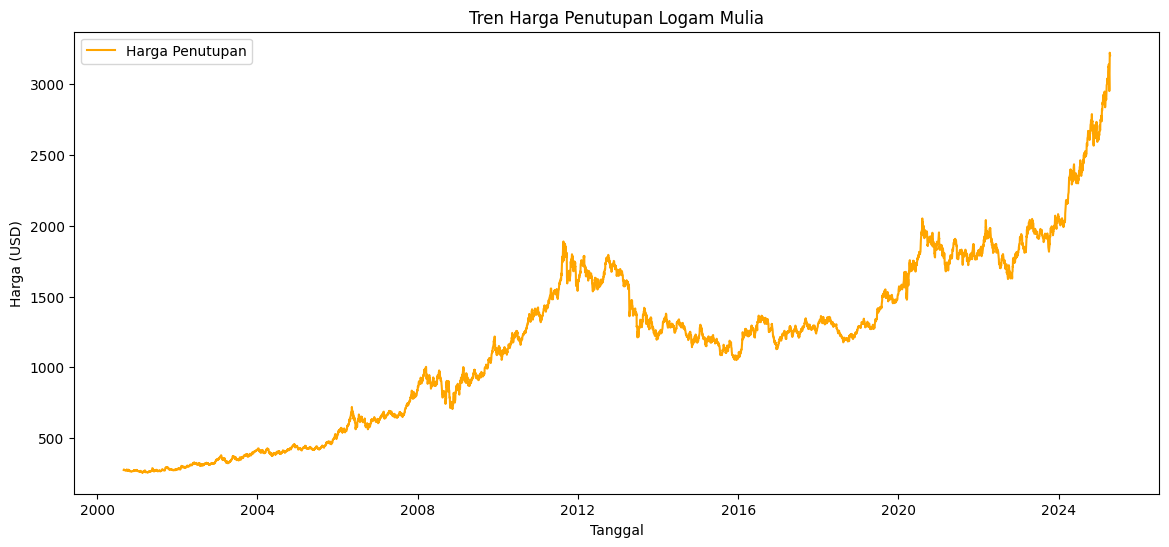

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(gold['timestamp'], gold['close'], label='Harga Penutupan', color='orange')
plt.title('Tren Harga Penutupan Logam Mulia')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

### **Analisis Tren Harga Penutupan Emas (2000–2025)**

### 1. Tren Jangka Panjang
- Harga emas menunjukkan **tren naik signifikan** dari kisaran **$250** pada tahun 2000 hingga mencapai lebih dari **$3.000** pada tahun 2025.
- Kenaikan ini bersifat **eksponensial**, terutama setelah tahun 2019, menandakan peningkatan permintaan atau ketidakstabilan ekonomi global yang memicu minat terhadap aset safe haven seperti logam mulia.

### 2. Fase Kenaikan dan Konsolidasi
- **2005–2011:** Periode pertumbuhan tajam, berakhir di puncak sekitar tahun 2011–2012.
- **2013–2018:** Fase konsolidasi dengan harga cenderung sideways (bergerak mendatar).
- **2020–2025:** Tren naik berlanjut dengan lonjakan harga yang curam, kemungkinan dipicu oleh pandemi, inflasi global, atau ketidakpastian geopolitik.

### 3. Volatilitas Harga
- Grafik memperlihatkan **fluktuasi tajam** di beberapa periode:
  - Koreksi signifikan pasca 2012.
  - Fluktuasi tinggi pada periode 2020–2022.
- Hal ini menunjukkan bahwa logam mulia merupakan aset dengan **volatilitas tinggi**, meskipun arah tren jangka panjang tetap naik.

### 4. Implikasi untuk Forecasting Time Series
- **Komponen tren kuat** → cocok untuk model seperti ARIMA dengan tren, Prophet, LSTM, atau GRU.
- **Musiman tidak terlihat jelas** secara visual, namun perlu dianalisis lebih lanjut menggunakan decomposisi statistik.
- **Volatilitas tinggi dan outlier** perlu ditangani secara khusus, terutama untuk model prediktif.

---

### **Kesimpulan Tren Harga Penutupan Emas**
- Harga logam mulia mengalami **apresiasi jangka panjang yang kuat**, menjadikannya aset menarik untuk investasi jangka panjang.
- Diperlukan **analisis lanjutan terhadap komponen musiman dan anomali data** sebelum dilakukan modeling prediktif.
- Cocok dijadikan objek pemodelan time series, terutama dengan pendekatan yang memperhitungkan tren dan volatilitas pasar.


## G. Visualisasi distribusi return harian

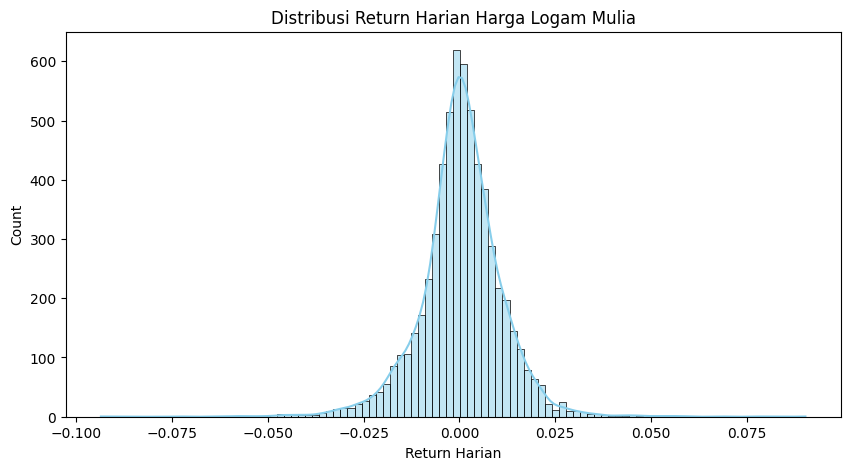

In [ ]:
gold['daily_return'] = gold['close'].pct_change()

plt.figure(figsize=(10,5))
sns.histplot(gold['daily_return'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Distribusi Return Harian Harga Logam Mulia')
plt.xlabel('Return Harian')
plt.show()

In [ ]:
gold['daily_return'].describe()

,daily_return
count,6176.000000
mean,0.000457
std,0.010864
min,-0.093538
25%,-0.004716
50%,0.000475
75%,0.006237
max,0.090277


### **Analisis Distribusi Return Harian Harga Emas**

### 1. Bentuk Distribusi
- Distribusi membentuk kurva **mendekati normal (bell-shaped)**.
- Terdapat **ekor tebal (fat tails)** di kiri dan kanan → menunjukkan distribusi **leptokurtik**.
- Artinya, meskipun sebagian besar perubahan harga harian kecil, ada **frekuensi signifikan dari perubahan ekstrem** (baik naik maupun turun).

### 2. Simetri dan Skewness
- Titik puncak berada sedikit di kanan nol → menunjukkan **sedikit skewness positif**.
- Ini menunjukkan bahwa **kenaikan kecil lebih sering terjadi** daripada penurunan kecil.

### 3. Implikasi untuk Investor dan Model
- Return harian **tidak sepenuhnya normal**, sehingga model statistik yang mengasumsikan normalitas mungkin **kurang akurat dalam memprediksi risiko ekstrem**.
- Penting untuk mempertimbangkan risiko outlier dalam perencanaan investasi dan pengelolaan risiko.

### **Kesimpulan Distribusi Return Harian**
Return harian harga logam mulia sebagian besar stabil, tetapi tetap memiliki kemungkinan **fluktuasi ekstrem**, sehingga analisis risiko perlu mempertimbangkan **tail risk**. Distribusi ini mencerminkan **volatilitas pasar yang moderat dengan kecenderungan positif jangka pendek**.


## H. Scatterplot volume vs harga penutupan

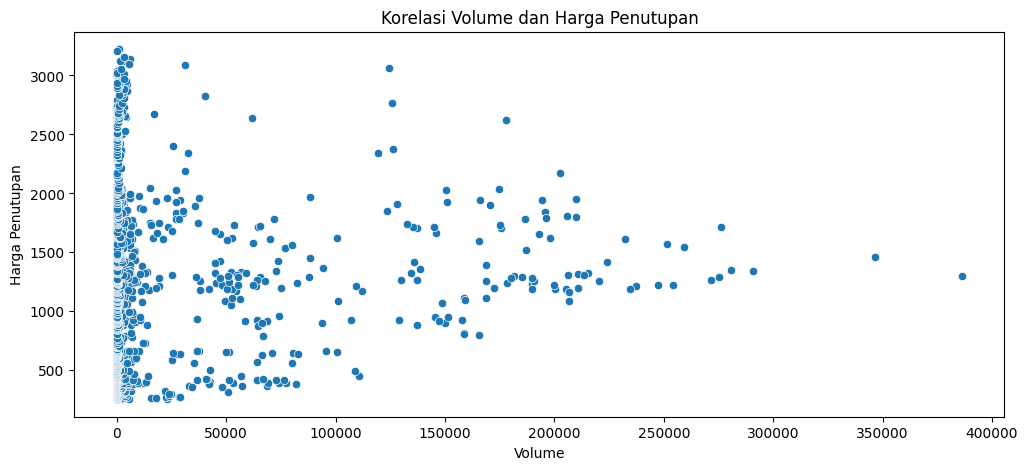

In [ ]:
plt.figure(figsize=(12,5))
sns.scatterplot(x='volume', y='close', data=gold)
plt.title('Korelasi Volume dan Harga Penutupan')
plt.xlabel('Volume')
plt.ylabel('Harga Penutupan')
plt.show()

### **Analisis Scatter Plot: Volume vs Harga Penutupan**

### 1. Distribusi Data
- Data menunjukkan bahwa sebagian besar volume transaksi berada di bawah **50.000 unit**, dengan konsentrasi titik yang sangat padat di area tersebut.
- Harga penutupan tersebar luas dari sekitar **250** hingga lebih dari **3000**, menunjukkan variasi harga yang besar.

### 2. Korelasi yang Lemah
- Tidak tampak pola linier atau tren yang jelas antara volume dan harga penutupan.
- Titik-titik data tersebar secara **acak dan menyebar horizontal**, tanpa kecenderungan menaik atau menurun.

### 3. Outlier
- Terdapat beberapa **outlier** pada volume yang sangat tinggi (misalnya > 200.000) dan harga penutupan ekstrem.
- Outlier ini tidak serta-merta menunjukkan hubungan sebab akibat antara volume dan harga.

> **Korelasi lemah atau mendekati nol** antara volume dan harga penutupan sudah sejalan dengan hasil matriks korelasi sebelumnya (sekitar 0.045).

### **Kesimpulan Scatter Plot Volume vs Harga Penutupan**
- Tidak ada hubungan yang signifikan antara volume dan harga penutupan logam mulia.
- Volume **tidak dapat dijadikan prediktor utama** untuk memodelkan harga penutupan secara linier.
- Untuk eksplorasi lebih lanjut, dapat dipertimbangkan pendekatan non-linier atau melihat variabel lain yang lebih relevan.



## I. Matriks korelasi antar variabel numerik

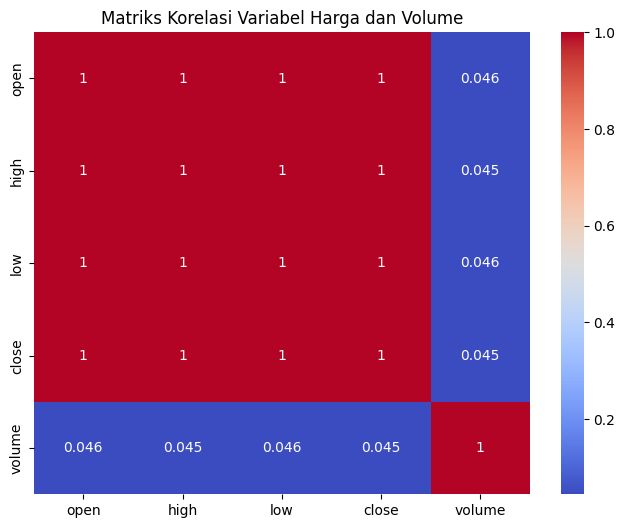

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(gold[['open', 'high', 'low', 'close', 'volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi Variabel Harga dan Volume')
plt.show()

### **Analisis Matriks Korelasi Variabel Harga dan Volume**

### 1. Korelasi Antar Harga (Open, High, Low, close)
- Nilai korelasi antara variabel `open`, `high`, `low`, dan `close` adalah **1.0**.
- Ini menunjukkan bahwa keempat harga ini **sangat berkorelasi sempurna** satu sama lain.
- Artinya, pergerakan salah satu jenis harga harian (misalnya harga penutupan) sangat mencerminkan pergerakan jenis harga lainnya.

> **Implikasi**: Variabel harga ini bersifat **redundan**. Untuk analisis lebih lanjut, cukup memilih satu di antara keempat variabel tersebut.

### 2. Korelasi Volume dengan Harga
- Korelasi antara `volume` dan keempat variabel harga berada di sekitar **0.045 – 0.046**, yang sangat **rendah**.
- Ini menunjukkan bahwa **volume perdagangan tidak memiliki hubungan linier yang signifikan** terhadap pergerakan harga.

> **Implikasi**: Volume dapat dipertimbangkan sebagai **variabel independen** dalam analisis prediktif harga, atau mungkin tidak relevan untuk model linier.

### **Kesimpulan Matriks Korelasi Variabel Harga dan Volume**
- Harga `open`, `high`, `low`, dan `close` sangat saling berkorelasi → cukup gunakan satu.
- Volume perdagangan **tidak berkorelasi signifikan** terhadap harga logam mulia.
- Analisis lanjutan mungkin memerlukan pendekatan non-linier jika ingin memanfaatkan volume sebagai fitur prediktif.



## J. Plot boxplot untuk melihat outlier pada harga

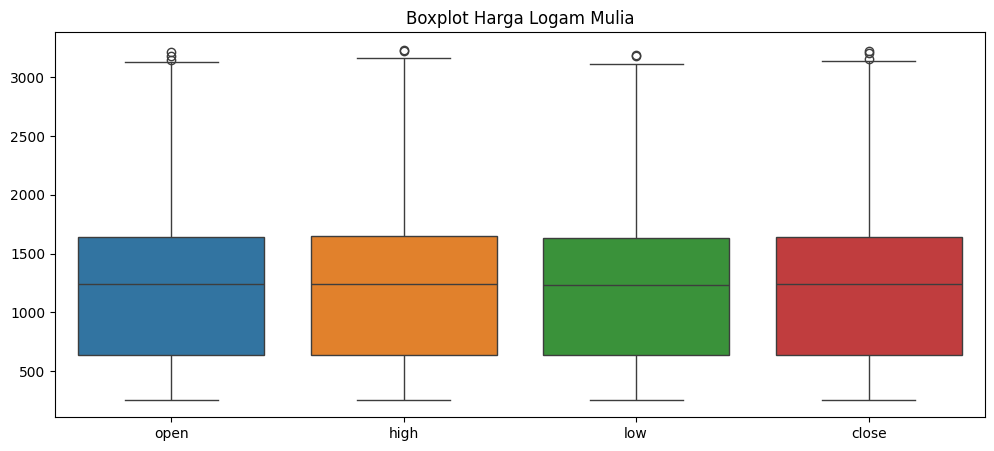

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(data=gold[['open', 'high', 'low', 'close']])
plt.title('Boxplot Harga Logam Mulia')
plt.show()

### **Analisis Boxplot Harga Emas**

### 1. Persebaran Harga
- Median dari semua variabel harga (`open`, `high`, `low`, `close`) berada di kisaran **1.200–1.300**, menunjukkan nilai tengah yang serupa antar semua jenis harga.
- Rentang interkuartil (IQR: Q3 - Q1) cukup lebar, menandakan **variabilitas harga yang tinggi**.

### 2. Simetri dan Kecenderungan
- Bentuk boxplot cukup simetris, menandakan **distribusi data relatif normal** meskipun terdapat kemiringan kecil pada beberapa harga.

### 3. Outlier
- Semua variabel menunjukkan **keberadaan outlier** yang signifikan, terutama di sisi atas (harga sangat tinggi > 3.000).
- Ini menunjukkan bahwa **ada beberapa hari dengan lonjakan harga yang ekstrem**, namun tidak sering terjadi.

### 4. Kesamaan Pola
- Keempat jenis harga (open, high, low, close) memiliki pola distribusi yang **mirip satu sama lain**, mendukung hasil korelasi sebelumnya yang sangat kuat antar variabel harga (semua korelasi = 1.00).
- Hal ini wajar dalam data pasar karena harga open, high, low, dan close pada satu hari biasanya berada dalam rentang yang berdekatan.

### **Kesimpulan Boxplot Harga Emas**
- Harga logam mulia memiliki distribusi yang seragam antar jenis harga.
- Perlu perhatian khusus terhadap **outlier**, terutama jika ingin menggunakan model statistik atau machine learning yang sensitif terhadap nilai ekstrem (misalnya regresi linear).


## K. Visualisasi volume perdagangan sepanjang waktu

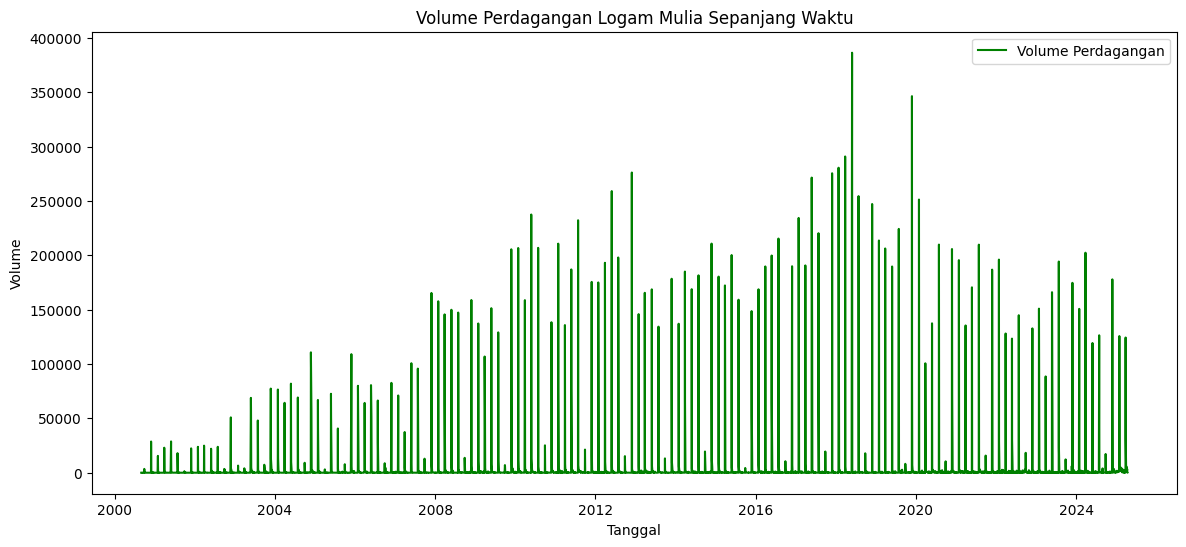

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(gold['timestamp'], gold['volume'], label='Volume Perdagangan', color='green')
plt.title('Volume Perdagangan Logam Mulia Sepanjang Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Volume')
plt.legend()
plt.show()

### **Analisis Volume Perdagangan Logam Mulia (2000–2025)**

### 1. Tren Umum
- Terjadi **kenaikan volume perdagangan** yang signifikan dari tahun 2000 hingga puncaknya sekitar tahun **2018–2019**.
- Setelah 2019, volume cenderung **menurun** dengan **fluktuasi tinggi**.

### 2. Puncak Aktivitas
- Volume tertinggi terjadi sekitar **2018–2019**, mendekati **400.000 unit transaksi**.
- Peningkatan volume ini bisa dikaitkan dengan:
  - Ketidakpastian ekonomi global (misalnya perang dagang, ketegangan geopolitik).
  - Minat tinggi terhadap logam mulia sebagai **aset lindung nilai (safe haven)**.

### 3. Fluktuasi
- Setelah puncaknya, volume menunjukkan **penurunan drastis** dan **volatilitas tinggi**.
- Periode **2020–2022** menunjukkan volume menurun tajam, kemungkinan dampak dari **pandemi COVID-19** yang memengaruhi pasar global.

### 4. Stabilitas Baru
- Dalam kurun waktu **2023–2025**, volume perdagangan cenderung **lebih stabil**, meski **masih belum setinggi sebelum 2020**.

### 5. Insight Potensial
- Lonjakan volume perdagangan dapat mencerminkan **ketertarikan investor** terhadap logam mulia di tengah ketidakpastian.
- Penurunan volume dapat menunjukkan **pergeseran minat investasi** ke instrumen lain seperti kripto atau saham.

---

### **Kesimpulan Volume Perdagangan Logam Mulia (2000–2025)**
- Volume perdagangan logam mulia tumbuh pesat hingga 2019.
- Terjadi penurunan dan fluktuasi akibat faktor eksternal seperti pandemi.
- Data ini berguna untuk menentukan **waktu ideal investasi** dan memahami **sentimen pasar** terhadap logam mulia.



## L. Analisis harga rata-rata per tahun

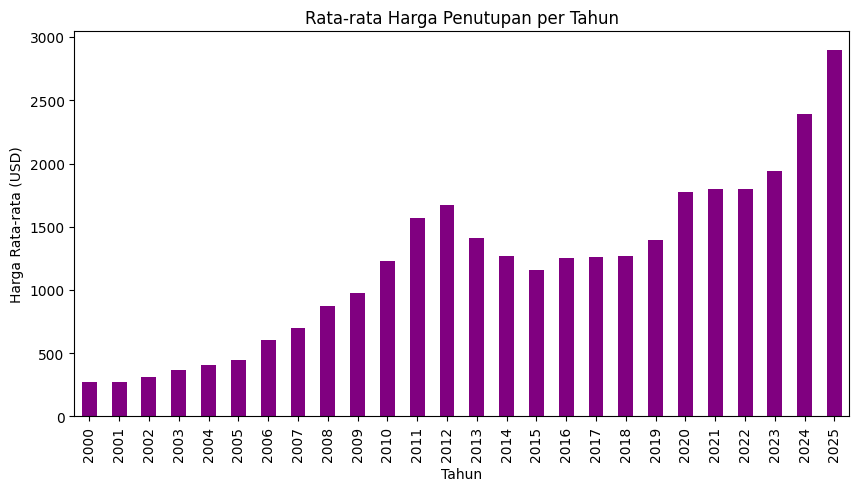

In [ ]:
gold['year'] = gold['timestamp'].dt.year
gold['month'] = gold['timestamp'].dt.month

annual_mean = gold.groupby('year')['close'].mean()
plt.figure(figsize=(10,5))
annual_mean.plot(kind='bar', color='purple')
plt.title('Rata-rata Harga Penutupan per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Harga Rata-rata (USD)')
plt.show()

### **Analisis Rata-rata Harga Penutupan Emas per Tahun (2000–2025)**

### 1. Trend Kenaikan Harga
- Harga rata-rata penutupan logam mulia meningkat secara signifikan dari sekitar **$270** di tahun 2000 menjadi hampir **$2.900** pada tahun 2025.
- Hal ini menunjukkan pertumbuhan nilai investasi logam mulia dalam jangka panjang.

### 2. Pertumbuhan Stabil di Awal 2000-an
- Pada rentang tahun 2000 hingga 2005, kenaikan harga relatif lambat namun konsisten.
- Pada periode 2006–2012 terjadi kenaikan yang sangat cepat, mencapai puncak di sekitar tahun 2011-2012.

### 3. Penurunan Rata-rata Harga Setelah 2012
- Terjadi penurunan rata-rata harga pada periode 2013 hingga 2018.
- Hal ini kemungkinan terkait koreksi pasar dan stabilisasi harga setelah lonjakan tajam sebelumnya.

### 4. Pemulihan dan Lonjakan Pasca 2019
- Setelah tahun 2019, harga rata-rata mengalami pemulihan kuat dan naik kembali.
- Lonjakan terbesar terjadi antara 2020 hingga 2025 dengan pertumbuhan yang tajam.
- Faktor yang memengaruhi termasuk kondisi ekonomi global, pandemi COVID-19, dan situasi geopolitik.

---

### **Kesimpulan Rata-rata Harga Penutupan Emas per Tahun (2000–2025)**
- Harga logam mulia menunjukkan **pertumbuhan jangka panjang yang signifikan**.
- Meskipun terjadi koreksi harga, tren keseluruhan tetap bullish.
- **Investasi logam mulia sangat menjanjikan untuk jangka panjang** dengan potensi keuntungan yang stabil dan berkelanjutan.


## M. Analisis harga rata-rata per bulan (gabungkan semua tahun)

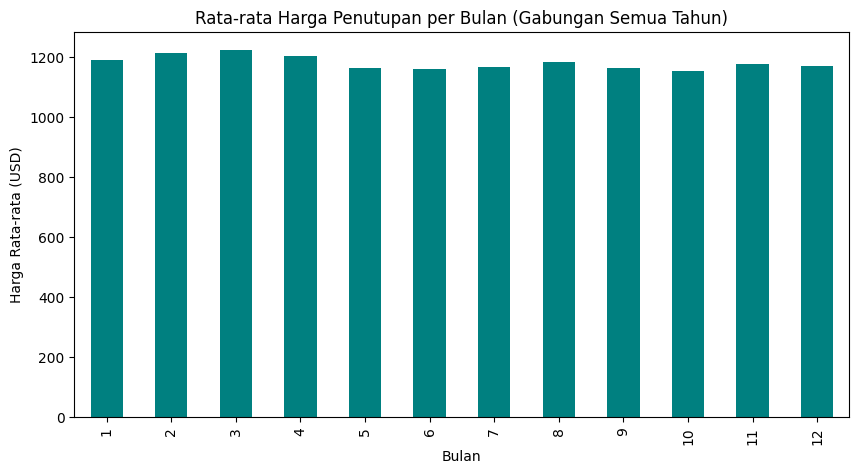

In [ ]:
monthly_mean = gold.groupby('month')['close'].mean()
plt.figure(figsize=(10,5))
monthly_mean.plot(kind='bar', color='teal')
plt.title('Rata-rata Harga Penutupan per Bulan (Gabungan Semua Tahun)')
plt.xlabel('Bulan')
plt.ylabel('Harga Rata-rata (USD)')
plt.show()

### **Analisis Rata-rata Harga Penutupan Logam Mulia per Bulan (Gabungan Semua Tahun)**

### 1. Pola Harga Bulanan
- Harga rata-rata penutupan logam mulia per bulan relatif stabil dengan variasi yang sangat kecil.
- Nilai rata-rata berada di kisaran **1.150 hingga 1.230 USD** sepanjang tahun.

### 2. Bulan dengan Harga Tertinggi
- Bulan Maret (bulan ke-3) menunjukkan harga rata-rata penutupan tertinggi, sekitar **1.225 USD**.
- Bulan Februari juga relatif tinggi, mendekati puncak harga di atas 1.210 USD.

### 3. Bulan dengan Harga Terendah
- Bulan Mei (bulan ke-5) dan Juni (bulan ke-6) menunjukkan harga rata-rata terendah, mendekati **1.160 USD**.
- Ini menunjukkan adanya sedikit penurunan harga di pertengahan tahun.

### 4. Interpretasi
- Fluktuasi harga bulanan yang kecil menunjukkan bahwa **harga logam mulia cenderung stabil dalam skala bulan sepanjang tahun**.
- Tidak ada pola musiman yang kuat terlihat, sehingga investasi jangka pendek dalam satu bulan tertentu tidak menunjukkan perbedaan signifikan.

---

### **Kesimpulan Rata-rata Harga Penutupan Logam Mulia per Bulan (Gabungan Semua Tahun)**
- Harga logam mulia bersifat stabil secara musiman.
- Investor bisa fokus pada tren jangka panjang daripada mencoba memanfaatkan variasi musiman bulanan.


## N. Plot rolling mean dan rolling std (untuk cek stasioneritas)

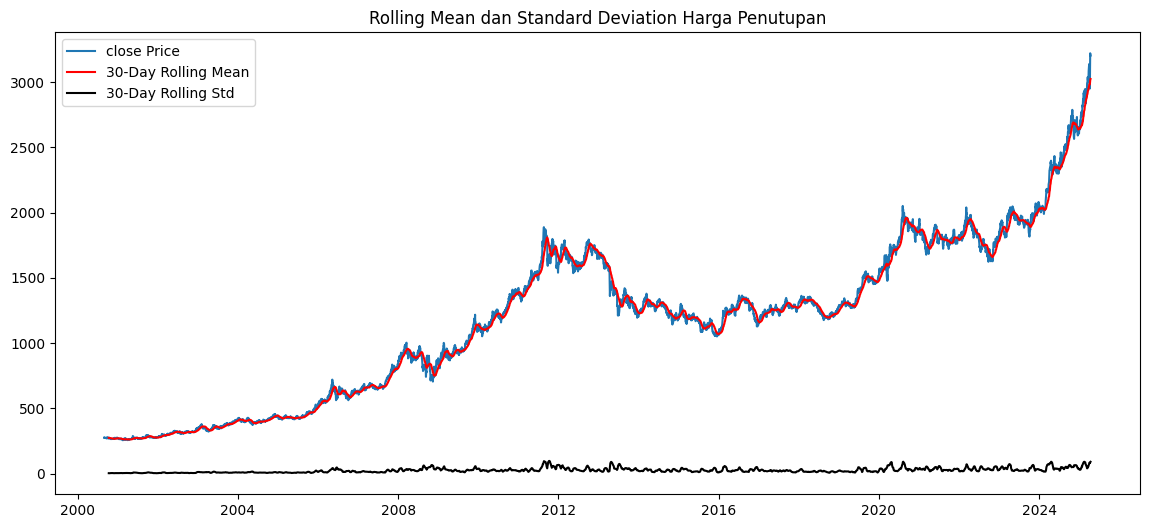

In [ ]:
window = 30  # 30 hari
rolling_mean = gold['close'].rolling(window=window).mean()
rolling_std = gold['close'].rolling(window=window).std()

plt.figure(figsize=(14,6))
plt.plot(gold['close'], label='close Price')
plt.plot(rolling_mean, color='red', label=f'{window}-Day Rolling Mean')
plt.plot(rolling_std, color='black', label=f'{window}-Day Rolling Std')
plt.title('Rolling Mean dan Standard Deviation Harga Penutupan')
plt.legend()
plt.show()

### **Analisis Rolling Mean dan Standard Deviation Harga Penutupan Emas**

### 1. Tren Harga Penutupan (close Price)
- Harga penutupan logam mulia menunjukkan tren naik yang cukup signifikan dari tahun 2000 hingga 2025.
- Terjadi beberapa periode koreksi harga, terutama sekitar tahun 2012 dan 2016, namun tren jangka panjang tetap naik.

### 2. Rolling Mean 30 Hari
- Garis merah yang merepresentasikan rata-rata bergerak (rolling mean) 30 hari mengikuti pergerakan harga penutupan dengan halus.
- Rolling mean menunjukkan smoothing yang membantu melihat tren jangka pendek secara lebih jelas dan mengurangi fluktuasi harian.

### 3. Rolling Standard Deviation 30 Hari
- Garis hitam menunjukkan volatilitas harga (standar deviasi) selama 30 hari.
- Volatilitas cenderung meningkat pada beberapa periode tertentu, terutama:
  - Sekitar tahun 2008-2012, kemungkinan terkait krisis keuangan global.
  - Pada tahun-tahun terakhir menuju 2025, yang menunjukkan ketidakstabilan harga yang lebih tinggi di pasar logam mulia.
- Periode dengan volatilitas rendah menunjukkan fase pasar yang relatif stabil.

### 4. Interpretasi
- Meskipun harga logam mulia mengalami tren kenaikan jangka panjang, ada fluktuasi dan ketidakpastian yang signifikan dalam periode tertentu.
- Investor harus waspada terhadap volatilitas ini karena bisa mempengaruhi risiko investasi.
- Rolling mean dapat digunakan sebagai indikator untuk mengidentifikasi tren harga dan potensi titik balik pasar.

---

### **Kesimpulan Rolling Mean dan Standard Deviation Harga Penutupan Emas**
- Harga logam mulia naik secara konsisten dalam jangka panjang dengan fluktuasi volatilitas yang bervariasi.
- Penggunaan rolling mean dan rolling standard deviation membantu memahami tren dan risiko pasar secara lebih efektif.


## O. Decompose time series (trend, seasonal, residual)

<Figure size 1400x1000 with 0 Axes>

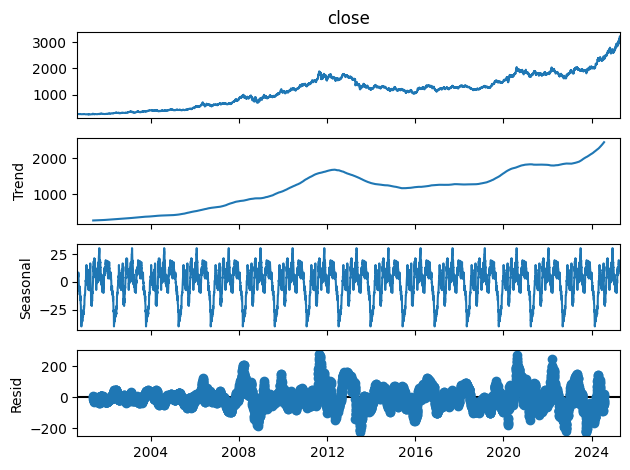

In [ ]:
decomposition = seasonal_decompose(gold['close'], model='additive', period=365) # asumsi data harian

plt.figure(figsize=(14,10))
decomposition.plot()
plt.show()

### **Analisis Dekomposisi Deret Waktu Harga Penutupan Emas**

### 1. Tren Harga Jangka Panjang (Trend)
- Komponen tren menunjukkan **kenaikan harga logam mulia yang stabil dari tahun 2000 hingga sekitar 2011**, disusul oleh **fase stagnasi atau penurunan ringan** antara 2012–2018.
- Setelah 2019, **tren naik kembali menguat**, mencerminkan permintaan yang meningkat atau faktor makroekonomi yang mendukung harga logam mulia.

### 2. Pola Musiman (Seasonality)
- Terdapat **pola musiman yang konsisten dan berulang** tiap tahun, dengan amplitudo sekitar ±25 unit.
- Fluktuasi musiman ini bisa terkait dengan **permintaan tahunan**, seperti musim perhiasan, festival, atau faktor ekonomi global yang berulang.
- Pola musiman **relatif stabil dari tahun ke tahun**, menunjukkan bahwa faktor musiman dapat diandalkan untuk analisis jangka pendek.

### 3. Komponen Residual (Sisa / Noise)
- Komponen residu menangkap **fluktuasi acak yang tidak dijelaskan oleh tren atau musim**.
- Terlihat bahwa **volatilitas residual meningkat secara signifikan setelah tahun 2010**, mencerminkan pasar yang lebih tidak stabil.
- Beberapa lonjakan ekstrem dalam residu terjadi selama periode krisis global atau ketidakpastian ekonomi (seperti 2008–2012 dan 2020–2025).

### 4. Interpretasi Umum
- **Tren naik jangka panjang** menunjukkan bahwa logam mulia tetap menjadi aset yang menarik untuk investasi jangka panjang.
- **Pola musiman yang stabil** dapat dimanfaatkan untuk strategi perdagangan berbasis waktu.
- **Volatilitas yang meningkat** pada komponen residual menunjukkan bahwa pasar menjadi lebih sensitif terhadap peristiwa global dan memerlukan perhatian khusus terhadap manajemen risiko.

---

### **Kesimpulan Analisis Dekomposisi Deret Waktu Harga Penutupan Emas**
- Harga logam mulia memiliki **fundamental jangka panjang yang kuat**, dengan tren naik dan pola musiman yang dapat diandalkan.
- **Dekomposisi deret waktu** memberikan wawasan yang lebih mendalam dibandingkan hanya melihat harga mentah, karena mampu memisahkan tren, musim, dan noise.
- **Investor dan analis dapat memanfaatkan komponen ini** untuk membangun model prediktif, mengidentifikasi momen optimal untuk masuk/keluar pasar, dan memahami risiko yang tersembunyi dalam volatilitas.


## P. Plot Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF)

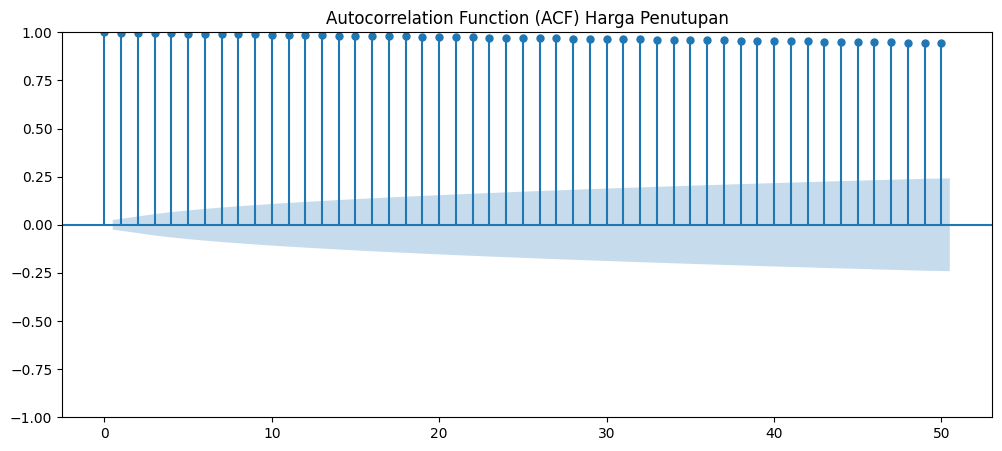

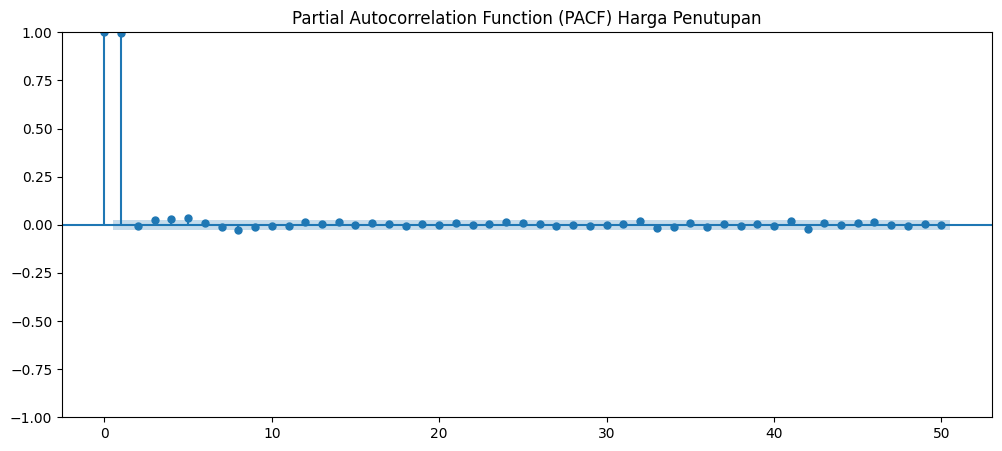

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(gold['close'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) Harga Penutupan')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(gold['close'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) Harga Penutupan')
plt.show()

### **Analisis Autocorrelation Function (ACF) Harga Penutupan Emas**

### 1. Korelasi Otokorelasi yang Sangat Tinggi
- Grafik menunjukkan bahwa **nilai ACF sangat tinggi (mendekati 1)** untuk semua lag hingga 50 hari.
- Ini mengindikasikan bahwa **harga penutupan hari ini sangat bergantung pada harga-harga sebelumnya** — terdapat **autokorelasi kuat** dalam data.

### 2. Tidak Ada Pemotongan Tajam (Cut-off)
- Tidak terlihat adanya penurunan cepat menuju nol atau osilasi bolak-balik (yang biasanya terjadi pada proses white noise atau ARMA).
- Hal ini mengisyaratkan bahwa data kemungkinan **non-stationary**, karena tren yang kuat menyebabkan korelasi tinggi terus berlanjut pada lag yang panjang.

### 3. Potensi Adanya Tren Jangka Panjang
- ACF seperti ini umum terjadi pada **data harga keuangan dengan tren**, seperti logam mulia, saham, atau indeks.
- **Model prediktif berbasis deret waktu (seperti ARIMA)** perlu melakukan transformasi data (misalnya differencing) agar stasioner sebelum digunakan untuk pemodelan.

---

### **Kesimpulan Autocorrelation Function (ACF) Harga Penutupan Emas**
- Data harga penutupan logam mulia menunjukkan **autokorelasi yang sangat kuat**, menunjukkan ketergantungan jangka panjang dan adanya tren.
- **Data belum stasioner**, sehingga perlu dilakukan **differencing** atau transformasi lainnya sebelum digunakan dalam model deret waktu seperti ARIMA atau SARIMA.
- ACF ini menguatkan temuan pada analisis tren sebelumnya — bahwa harga bergerak dengan arah tertentu dan tidak acak.


## Q. Plot return harian sepanjang waktu (volatility)

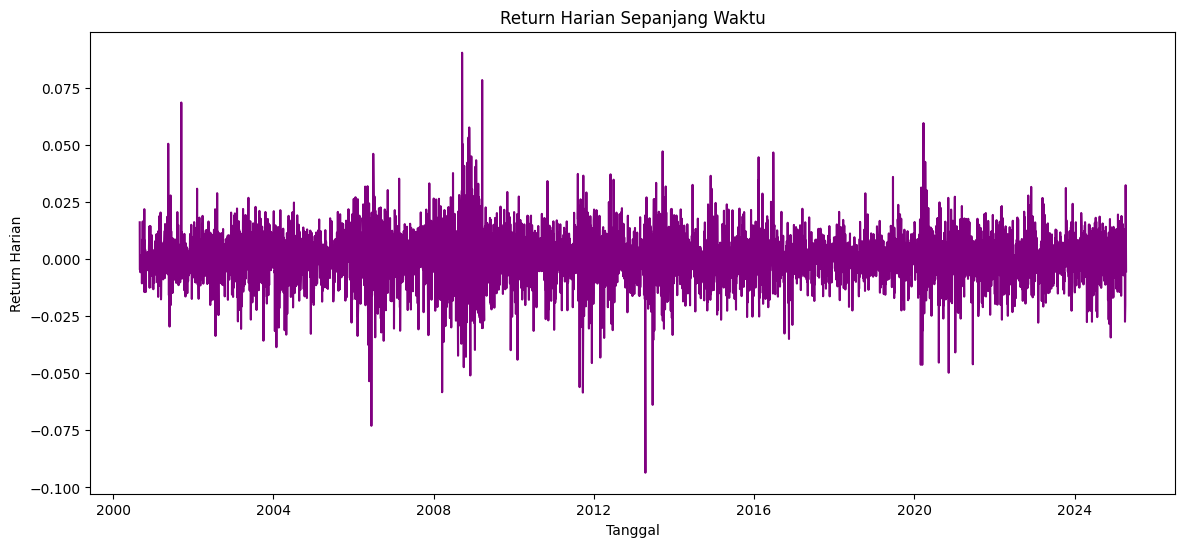

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(gold['daily_return'], color='purple')
plt.title('Return Harian Sepanjang Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Return Harian')
plt.show()

### **Analisis Return Harian Harga Emas (2000–2025)**

### 1. Distribusi Return Mengelilingi Nol
- Return harian berfluktuasi di sekitar nilai **0**, yang merupakan karakteristik umum aset keuangan.
- Hal ini menunjukkan bahwa **tidak terdapat kecenderungan sistematis** untuk return positif atau negatif dalam jangka pendek.
- Fluktuasi yang acak mengindikasikan bahwa **return harian sulit diprediksi** tanpa model statistik yang lebih kompleks.

### 2. Volatilitas Tidak Konsisten (Volatility Clustering)
- Terlihat jelas adanya **periode dengan volatilitas tinggi**, di mana return harian sangat bervariasi, dan periode lainnya yang lebih stabil.
- Pola ini dikenal sebagai **volatility clustering**, yaitu kecenderungan volatilitas tinggi diikuti oleh volatilitas tinggi, dan sebaliknya.
- Periode dengan volatilitas tinggi antara lain:
  - Sekitar **2008–2011**, yang sesuai dengan **krisis keuangan global**.
  - Tahun **2020**, saat terjadi **ketidakpastian ekonomi akibat pandemi COVID-19**.

### 3. Pergerakan Ekstrem (Outliers)
- Beberapa titik return harian menunjukkan perubahan ekstrem (baik positif maupun negatif), seperti lonjakan di atas **0.08** atau penurunan tajam di bawah **-0.08**.
- Outlier ini biasanya berkaitan dengan **berita besar**, **kejadian geopolitik**, atau **intervensi pasar**.

---

### **Kesimpulan Analisis Return Harian Harga Emas (2000–2025)**
- Return harian logam mulia menunjukkan perilaku yang **volatil dan tidak stabil**, dengan fluktuasi acak yang mengelilingi nilai nol.
- **Volatility clustering** dan kehadiran **outlier** menandakan bahwa model statistik seperti **GARCH** dapat lebih tepat digunakan untuk memodelkan dinamika volatilitas.
- Investor perlu mempertimbangkan **risiko jangka pendek yang tinggi**, meskipun tren jangka panjang logam mulia cenderung positif.


## R. Visualisasi outlier dengan boxplot return harian

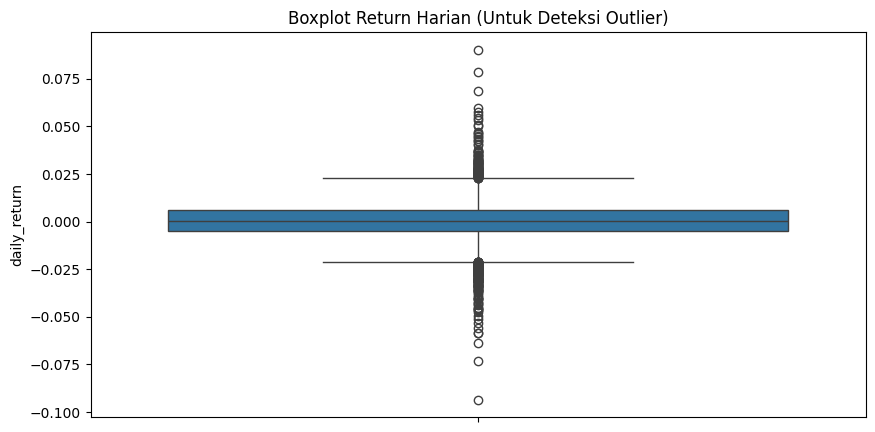

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(gold['daily_return'].dropna())
plt.title('Boxplot Return Harian (Untuk Deteksi Outlier)')
plt.show()

### **Analisis Boxplot Return Harian Emas (Deteksi Outlier)**

### 1. Persebaran Return Harian
- Mayoritas return harian berada di sekitar nilai **0**, menunjukkan bahwa sebagian besar perubahan harga harian logam mulia bersifat kecil dan stabil.
- Nilai median return berada sangat dekat dengan nol, menunjukkan **simetri** dalam distribusi return.

### 2. Rentang Interkuartil (IQR)
- **Box (kotak)** mewakili rentang interkuartil (antara Q1 dan Q3), yaitu 50% nilai return harian.
- Rentang IQR cukup sempit, menunjukkan bahwa fluktuasi normal harian biasanya kecil.

### 3. Outlier Ekstrem
- Titik-titik di luar garis "whiskers" (jangkauan normal data) merupakan **outlier** — yaitu perubahan harga harian yang tidak biasa.
- Terdapat banyak **outlier positif dan negatif**, mencerminkan:
  - **Peristiwa pasar ekstrem**, seperti krisis keuangan, pandemi, atau intervensi pemerintah.
  - Potensi **volatilitas tinggi pada hari-hari tertentu**.

### 4. Implikasi terhadap Risiko
- Kehadiran outlier dalam jumlah signifikan menunjukkan bahwa pasar logam mulia memiliki **fat tails** (ekor distribusi yang tebal).
- Ini menandakan bahwa kejadian ekstrem lebih sering terjadi dibandingkan asumsi distribusi normal, yang penting untuk:
  - **Manajemen risiko**
  - **Perhitungan Value-at-Risk (VaR)**
  - **Pemodelan distribusi return dengan pendekatan non-parametrik atau distribusi heavy-tailed seperti t-distribution**

---

### **Kesimpulan Boxplot Return Harian Emas (Deteksi Outlier)**
- Return harian logam mulia umumnya stabil, namun terdapat cukup banyak **outlier ekstrem**.
- Boxplot ini mengonfirmasi bahwa risiko kejadian langka namun berdampak besar perlu diperhitungkan dalam strategi investasi dan manajemen portofolio.


## S. Word Cloud dari kolom headlines

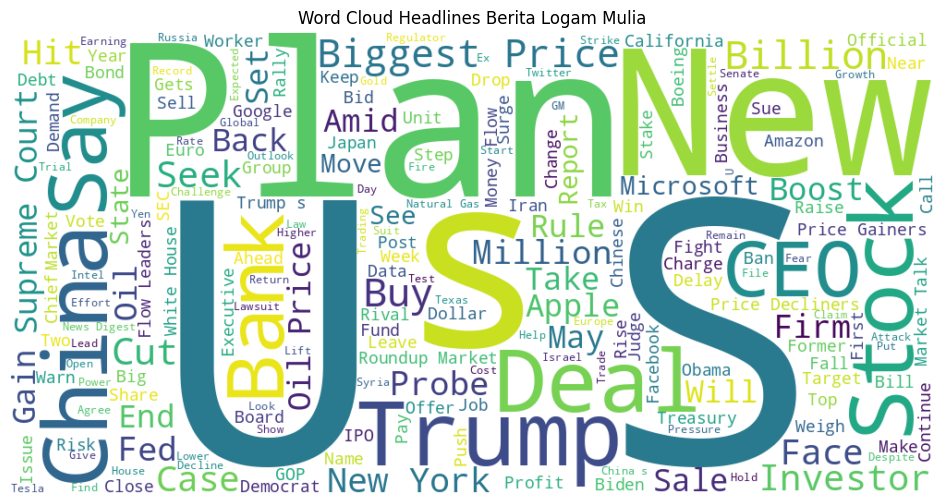

In [ ]:
text = ' '.join(gold['headlines'].dropna().astype(str))

wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Headlines Berita Logam Mulia')
plt.show()


### **Analisis Word Cloud dari Berita Logam Mulia**

### 1. Kata-Kata Paling Dominan
- Kata-kata yang paling menonjol dalam word cloud antara lain:
  - **"News"**, **"US"**, **"Plan"**, **"Deal"**, **"Trump"**, **"Bank"**, **"Stock"**, dan **"Price"**.
- Ini menunjukkan bahwa berita logam mulia seringkali berkaitan dengan isu-isu ekonomi makro dan geopolitik global.

### 2. Pengaruh Politik dan Ekonomi Global
- Kata **"Trump"**, **"China"**, dan **"Biden"** mencerminkan pengaruh kuat dari kebijakan pemerintah dan ketegangan geopolitik terhadap pasar logam mulia.
- Kata **"Bank"**, **"Investor"**, dan **"Debt"** menunjukkan perhatian pasar terhadap kebijakan moneter dan sektor keuangan.

### 3. Fokus pada Pasar dan Harga
- Kehadiran kata **"Price"**, **"Stock"**, **"Market"**, dan **"Oil"** menegaskan bahwa berita yang berkaitan dengan pergerakan harga dan pasar komoditas sangat relevan terhadap dinamika logam mulia.
- Kata **"Gold"** juga muncul, mengindikasikan hubungan langsung antara berita dan instrumen logam mulia tersebut.

### 4. Aktivitas Korporat dan Eksekutif
- Kata-kata seperti **"CEO"**, **"Microsoft"**, **"Apple"**, dan **"Firm"** menunjukkan bahwa berita korporat dan pernyataan eksekutif juga berpengaruh pada sentimen pasar logam mulia.

---

### **Kesimpulan Word Cloud dari Berita Logam Mulia**
- Word cloud ini mengilustrasikan bahwa sentimen dan headline berita mengenai logam mulia banyak dipengaruhi oleh:
  - Faktor makroekonomi (bank, utang, harga minyak)
  - Isu geopolitik dan politik (AS, China, Trump, Biden)
  - Berita korporat dan eksekutif besar (CEO, Apple, Microsoft)
- Investor dapat memanfaatkan analisis headline ini sebagai **indikator sentimen pasar** untuk memperkirakan arah pergerakan logam mulia.


## T. Analisis panjang teks headlines

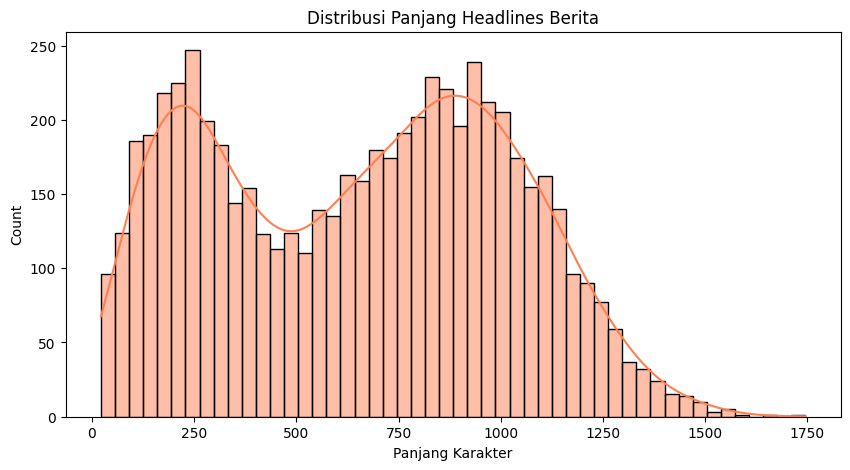

In [ ]:
gold['headline_length'] = gold['headlines'].fillna('').apply(len)

plt.figure(figsize=(10,5))
sns.histplot(gold['headline_length'], bins=50, kde=True, color='coral')
plt.title('Distribusi Panjang Headlines Berita')
plt.xlabel('Panjang Karakter')
plt.show()

### Insight:

Sebagian besar headline berita memiliki panjang karakter antara **200–300** dan **800–1000**. Distribusinya bersifat **bimodal**, menunjukkan dua kelompok utama dalam panjang penulisan headline. Panjang ekstrem di atas 1300 karakter relatif jarang.


## U. Analisis Sentiment headlines

Melakukan analisis sentiment headlines denan menggunakan VADER (Valence Aware Dictionary and sEntiment Reasoner), VADER sangat cocok untuk menganalisis sentimen pada headlines berita karena dirancang efektif untuk memproses teks pendek. Selain itu, VADER mempertimbangkan intensitas sentimen dan tidak memerlukan pelatihan data khusus, menjadikannya pilihan yang cepat dan mudah untuk mengevaluasi nuansa positif, negatif, atau netral dalam analisis sentiment headlines

In [ ]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Membuat kolom 'skor' menggunakan analisis sentimen VADER pada berita utama

In [ ]:
gold['scores'] = gold['headlines'].apply(lambda headlines: sid.polarity_scores(headlines))
gold.head()

,timestamp,open,high,low,close,volume,currency,unit,headlines,daily_return,year,month,headline_length,scores,compound,sentiment_type
timestamp_raw,,,,,,,,,,,,,,,,
2000-08-30,2000-08-30,273.9,273.9,273.9,273.9,0,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,NaN,2000,8,458,"{'neg': 0.106, 'neu': 0.74, 'pos': 0.155, 'com...",0.5719,POSITIVE
2000-08-31,2000-08-31,274.8,278.3,274.8,278.3,0,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,0.016064,2000,8,495,"{'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...",0.7059,POSITIVE
2000-09-01,2000-09-01,277.0,277.0,277.0,277.0,0,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.004671,2000,9,618,"{'neg': 0.024, 'neu': 0.87, 'pos': 0.105, 'com...",0.7650,POSITIVE
2000-09-05,2000-09-05,275.8,275.8,275.8,275.8,2,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.004332,2000,9,316,"{'neg': 0.041, 'neu': 0.762, 'pos': 0.197, 'co...",0.8316,POSITIVE
2000-09-06,2000-09-06,274.2,274.2,274.2,274.2,0,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.005801,2000,9,230,"{'neg': 0.166, 'neu': 0.695, 'pos': 0.139, 'co...",-0.0258,NEGATIVE


Ekstrak skor gabungan dan menetapkan jenis sentimen (POSITIVE, NEUTRAL, NEGATIVE) berdasarkan nilai compound

In [ ]:
gold['compound'] = gold['scores'].apply(lambda score_dict: score_dict['compound'])
gold['sentiment_type']=''
gold.loc[gold.compound>0,'sentiment_type']='POSITIVE'
gold.loc[gold.compound==0,'sentiment_type']='NEUTRAL'
gold.loc[gold.compound<0,'sentiment_type']='NEGATIVE'
gold.head()

,timestamp,open,high,low,close,volume,currency,unit,headlines,daily_return,year,month,headline_length,scores,compound,sentiment_type
timestamp_raw,,,,,,,,,,,,,,,,
2000-08-30,2000-08-30,273.9,273.9,273.9,273.9,0,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,NaN,2000,8,458,"{'neg': 0.106, 'neu': 0.74, 'pos': 0.155, 'com...",0.5719,POSITIVE
2000-08-31,2000-08-31,274.8,278.3,274.8,278.3,0,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,0.016064,2000,8,495,"{'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...",0.7059,POSITIVE
2000-09-01,2000-09-01,277.0,277.0,277.0,277.0,0,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.004671,2000,9,618,"{'neg': 0.024, 'neu': 0.87, 'pos': 0.105, 'com...",0.7650,POSITIVE
2000-09-05,2000-09-05,275.8,275.8,275.8,275.8,2,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.004332,2000,9,316,"{'neg': 0.041, 'neu': 0.762, 'pos': 0.197, 'co...",0.8316,POSITIVE
2000-09-06,2000-09-06,274.2,274.2,274.2,274.2,0,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.005801,2000,9,230,"{'neg': 0.166, 'neu': 0.695, 'pos': 0.139, 'co...",-0.0258,NEGATIVE


Menampilkan persentase sentimen emas dari tahun 2020 sampai 2025

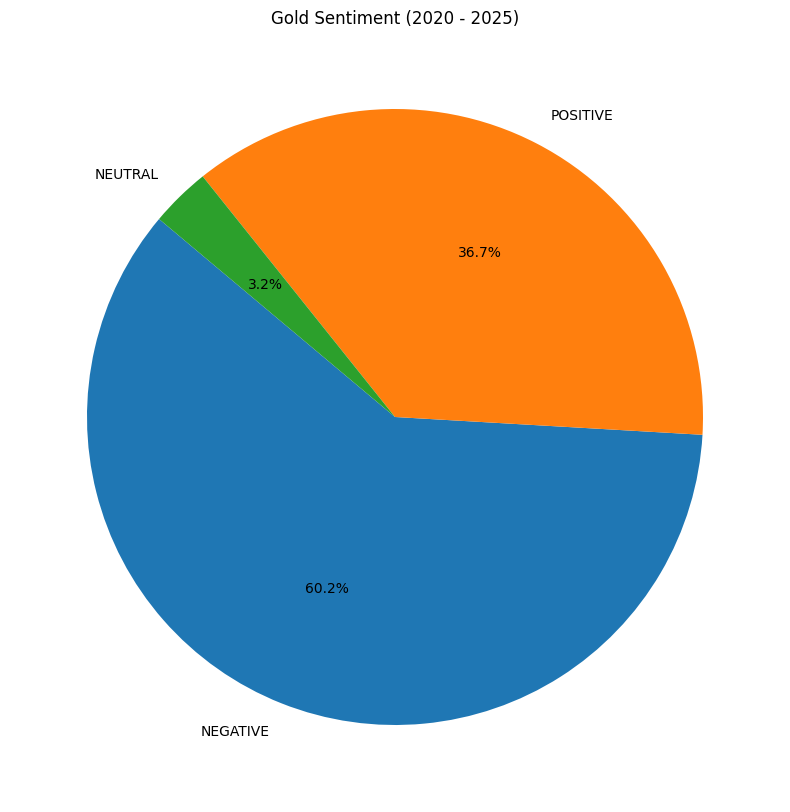

In [ ]:
gold_sent = gold['sentiment_type'].value_counts()

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(gold_sent.values, labels=gold_sent.index, autopct='%1.1f%%', startangle=140)
ax.set_title("Gold Sentiment (2020 - 2025)")
plt.show()

#### **Insight Gold Sentiment (2020–2025)**

* **Sentimen negatif mendominasi**: 60,2% dari seluruh sentimen terhadap emas bersifat negatif.
* **Sentimen positif** cukup signifikan: 36,7%, menunjukkan masih ada kepercayaan pasar.
* **Sentimen netral** sangat kecil: hanya 3,2%, menandakan opini pasar terhadap emas cenderung tegas (positif atau negatif), bukan netral.


### Perbedaan Harga Pembukaan dan Penutupan

Membuat kolom difference yang menangkap perubahan antara nilai open dan close


In [ ]:
gold['difference'] = gold['open']-gold['close']
gold.head()

,timestamp,open,high,low,close,volume,currency,unit,headlines,daily_return,year,month,headline_length,scores,compound,sentiment_type,difference
timestamp_raw,,,,,,,,,,,,,,,,,
2000-08-30,2000-08-30,273.9,273.9,273.9,273.9,0,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,NaN,2000,8,458,"{'neg': 0.106, 'neu': 0.74, 'pos': 0.155, 'com...",0.5719,POSITIVE,0.0
2000-08-31,2000-08-31,274.8,278.3,274.8,278.3,0,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,0.016064,2000,8,495,"{'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...",0.7059,POSITIVE,-3.5
2000-09-01,2000-09-01,277.0,277.0,277.0,277.0,0,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.004671,2000,9,618,"{'neg': 0.024, 'neu': 0.87, 'pos': 0.105, 'com...",0.7650,POSITIVE,0.0
2000-09-05,2000-09-05,275.8,275.8,275.8,275.8,2,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.004332,2000,9,316,"{'neg': 0.041, 'neu': 0.762, 'pos': 0.197, 'co...",0.8316,POSITIVE,0.0
2000-09-06,2000-09-06,274.2,274.2,274.2,274.2,0,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.005801,2000,9,230,"{'neg': 0.166, 'neu': 0.695, 'pos': 0.139, 'co...",-0.0258,NEGATIVE,0.0


In [ ]:
# Ekstrak tahun dari timestamp
gold.loc[:, 'year'] = gold['timestamp'].dt.year

# Jumlahkan nilai 'difference' untuk setiap tahun
gold_yearly = gold.groupby('year').agg({'difference': 'sum'})

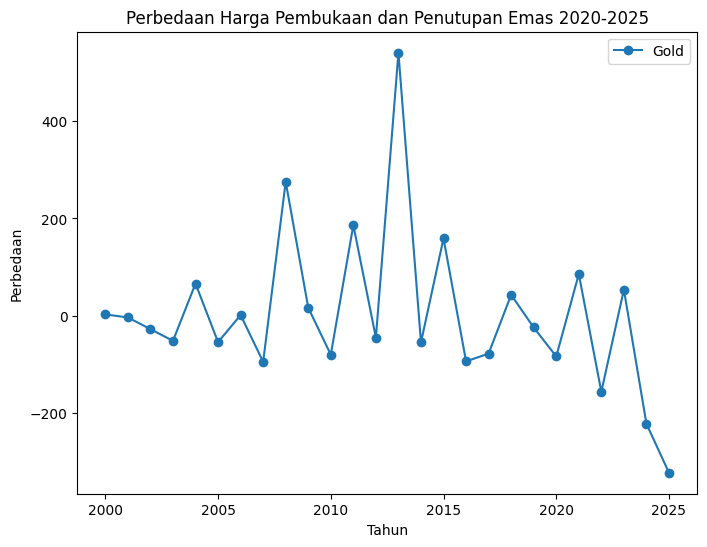

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(gold_yearly.index, gold_yearly.values, marker = 'o', label='Gold')
ax.set_title('Perbedaan Harga Pembukaan dan Penutupan Emas 2020-2025')
ax.set_xlabel("Tahun")
ax.set_ylabel('Perbedaan')
ax.legend()

#### **Analisis Grafik Perbedaan Harga Emas (2020–2025)**

1. **Fluktuasi Tajam**
   Perbedaan harga penutupan dan pembukaan emas sangat tidak stabil dari tahun ke tahun.

2. **Penurunan Tajam di 2025**
   Tahun 2025 menunjukkan selisih negatif terbesar, mengindikasikan penurunan harga emas signifikan.

3. **2020–2022 Stabil, 2023–2025 Menurun**
   Awal periode cukup stabil, namun tren menurun dimulai 2023 dan memburuk hingga 2025.



### **Sentiment and Price Movement Correlation**
Untuk menganalisis hubungan antara sentimen dan selisih harga emas, saya mengonversi sentimen menjadi angka: **Positif = 1, Netral = 0, Negatif = -1**, lalu menghitung korelasi Pearson antara keduanya.


In [ ]:
def map_sentiment_and_corr(df, sentiment_map):
    df['sentiment_numeric'] = df['sentiment_type'].map(sentiment_map)
    return df['difference'].corr(df['sentiment_numeric'])

sentiment_map = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
gold_corr = map_sentiment_and_corr(gold, sentiment_map)

print(f"Gold Correlation: {gold_corr}")


Gold Correlation: 0.0032407107049226475


Emas menunjukkan korelasi negatif yang sangat kecil dengan sentimen, yang menunjukkan bahwa sentimen hampir tidak memiliki kekuatan prediktif untuk perbedaan harga penutupan-terbuka selama periode yang dianalisis.

> Karena korelasi antara sentimen dari judul berita dan perbedaan harga emas terbukti lemah, kolom headlines tidak digunakan dalam proses pemodelan. Selain itu, hanya kolom close yang digunakan, sementara kolom open, high, dan low diabaikan karena dianggap redundan dan tidak memberikan informasi tambahan yang signifikan.

## Menyimpan Dataset Hasil EDA

In [ ]:
gold.to_csv('eda_gold_dataset.csv', index=False)

# 4. Preprocesing Data
- Feature Selction
- Interpolasi
- Normalisasi dan Pembentukan Data Time Series
- Pembagian Dataset Time Series (Train, Validation, Test)  

### Feature Selection

Kode ini menyaring kolom penting dan mengatur ulang indeks, biasanya dilakukan saat:

- Membersihkan data sebelum modeling.

- Menyederhanakan data sebelum ekspor.

- Menghindari indeks yang tidak relevan (misalnya, jika sebelumnya multi-index atau tanggal).

In [ ]:
gold = gold[['timestamp', 'close']].reset_index(drop=True)
gold

,timestamp,close
0,2000-08-30,273.9
1,2000-08-31,278.3
2,2000-09-01,277.0
3,2000-09-05,275.8
4,2000-09-06,274.2
...,...,...
6172,2025-04-08,2968.4
6173,2025-04-09,3056.5
6174,2025-04-10,3155.2
6175,2025-04-11,3222.2


### Interpolasi
Kode berikut bertujuan untuk mengisi kekosongan tanggal dan menyusun ulang DataFrame gold agar punya baris untuk setiap hari atau bahkan jika tidak ada data sebelumnya untuk hari-hari tertentu.

In [ ]:
gold.set_index('timestamp', inplace=True)
date_range = pd.date_range(start=gold.index.min(), end=gold.index.max(), freq='D')
gold = gold.reindex(date_range)
gold.reset_index(inplace=True)
gold.rename(columns={'index': 'timestamp'}, inplace=True)
gold

,timestamp,close
0,2000-08-30,273.9
1,2000-08-31,278.3
2,2000-09-01,277.0
3,2000-09-02,NaN
4,2000-09-03,NaN
...,...,...
8989,2025-04-10,3155.2
8990,2025-04-11,3222.2
8991,2025-04-12,NaN
8992,2025-04-13,NaN


In [ ]:
# Ubah kolom Tanggal menjadi datetime
gold['timestamp'] = pd.to_datetime(gold['timestamp'])

# Set kolom Tanggal sebagai index
gold.set_index('timestamp', inplace=True)

# Interpolate nilai missing dengan rata-rata hari sebelumnya dan setelahnya
gold['close'] = gold['close'].interpolate(method='linear')
gold.reset_index(inplace=True)
gold

,timestamp,close
0,2000-08-30,273.9
1,2000-08-31,278.3
2,2000-09-01,277.0
3,2000-09-02,276.7
4,2000-09-03,276.4
...,...,...
8989,2025-04-10,3155.2
8990,2025-04-11,3222.2
8991,2025-04-12,3216.4
8992,2025-04-13,3210.6


Dari hasil interpolasi, dataset bertambah menjadi sebanyak 8994 baris.

### Normalisasi dan Pembentukan Data Time Series untuk Model GRU
**Fungsi Kode**:  
Kode ini bertujuan untuk menyiapkan data time series agar dapat digunakan dalam model deep learning seperti GRU. Proses ini meliputi normalisasi data harga penutupan dan pembentukan data dalam bentuk sekuens sliding window.

**Langkah-langkah**:
1. **Normalisasi Data**:
   - Kolom `'close'` dinormalisasi ke dalam rentang [0, 1] menggunakan `MinMaxScaler()` dari `sklearn`, dan hasilnya disimpan ke kolom baru `'close_s'`.
   - Tujuannya adalah agar model lebih mudah belajar dan konvergen lebih cepat saat training.

2. **Fungsi Pembentukan Sekuens**:
   - Fungsi `create_sequences()` membuat data input `X` dan target `y` untuk model time series.
   - Menggunakan pendekatan *sliding window* sebesar `window_size`, yaitu 60 data sebelumnya digunakan untuk memprediksi data ke-61.
   - Data input (`X`) berupa array 2D dari sekuens, dan target (`y`) adalah nilai setelah sekuens.

3. **Penerapan dan Reshape**:
   - Nilai series diambil dari kolom `'close_s'` yang telah dinormalisasi.
   - Data `X` dibentuk ulang ke dalam dimensi `(samples, timesteps, features)` menjadi `(N, 60, 1)`, sesuai input standar model GRU.



4. **Output Dimensi**:
   - Dicetak dimensi hasil `X` dan `y` untuk memastikan bentuk input sudah sesuai.


**Keuntungan**:
- Normalisasi membantu mempercepat konvergensi model dan menghindari dominasi fitur dengan skala besar.
- Pembentukan sekuens memungkinkan pemodelan dependensi temporal yang sangat penting dalam prediksi time series.
- Format `(samples, timesteps, features)` kompatibel langsung dengan arsitektur GRU di Keras atau PyTorch.

**Insight**:
- Proses ini menghasilkan pasangan input-output yang merepresentasikan dinamika harga emas dalam 60 hari terakhir untuk memprediksi harga hari berikutnya.
- Ideal untuk digunakan dalam model GRU karena menangkap pola historis dan fluktuasi jangka pendek secara eksplisit.



In [ ]:
gold_scaler = MinMaxScaler()
gold['close_s'] = gold_scaler.fit_transform(gold[['close']])
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series)-window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

WINDOW = 60
series = gold['close_s'].values
X, y = create_sequences(series, WINDOW)
X = X.reshape((X.shape[0], WINDOW, 1))
print(f"Shape X: {X.shape}, y: {y.shape}")

Shape X: (8934, 60, 1), y: (8934,)



### Pembagian Dataset Time Series (Train, Validation, Test)
**Fungsi Kode**:  
Kode ini digunakan untuk membagi dataset yang telah dibentuk menjadi sekuens menjadi tiga bagian utama: **training**, **validation**, dan **testing**, sesuai dengan proporsi yang umum digunakan dalam pelatihan model machine learning dan deep learning.

**Langkah-langkah**:
1. **Menentukan Ukuran Dataset**:
   - Variabel `total` menyimpan jumlah total sampel dalam array `X`.
   - Indeks akhir untuk data training dan validation dihitung berdasarkan proporsi:
     - 70% untuk **train**
     - 15% untuk **validation**
     - 15% sisanya untuk **test**



2. **Pembagian Dataset**:
   - Data dibagi menggunakan slicing berdasarkan indeks yang telah dihitung:
     - `X_train`, `y_train` untuk pelatihan model.
     - `X_val`, `y_val` untuk validasi selama proses pelatihan.
     - `X_test`, `y_test` untuk evaluasi akhir performa model.



3. **Pengecekan Bentuk Data**:
   - Menampilkan ukuran masing-masing subset untuk memastikan pembagian data sudah sesuai proporsi dan tidak terjadi kehilangan data.


**Keuntungan**:
- Pembagian data secara berurutan (bukan acak) menjaga urutan temporal pada data time series, yang penting untuk menghindari *data leakage*.
- Memberikan struktur yang baik untuk pelatihan, tuning, dan evaluasi model secara terpisah.
- Memastikan generalisasi model tidak hanya berdasarkan data yang pernah dilihat selama pelatihan.

**Insight**:
- Proporsi 70:15:15 merupakan pilihan seimbang untuk proyek deep learning skala sedang.
- Validation set digunakan untuk menghindari overfitting, sedangkan test set akan mencerminkan kemampuan model pada data nyata yang belum pernah dilihat.



In [ ]:
total = len(X)
train_end = int(total*0.7)
val_end = train_end + int(total*0.15)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (6253, 60, 1), Val: (1340, 60, 1), Test: (1341, 60, 1)


# 5. Pembangunan dan Evaluasi Model GRU (Tuning)

### Hyperparameter Tuning GRU dengan Hyperopt
**Fungsi Kode**:  
Fungsi ini digunakan untuk pencarian kombinasi hyperparameter terbaik dengan model GRU menggunakan `Hyperopt`.

**Langkah-langkah**:
1. **Penetapan Seed (Reproducibility)**:
   - Seed untuk `random`, `numpy`, dan `tensorflow` diset untuk memastikan hasil eksperimen konsisten dan dapat direproduksi.


2. **Arsitektur Model**:
   - Model didefinisikan sebagai `Sequential` dengan tiga lapisan utama:
     - `Input`: Berbentuk `(WINDOW, 1)` sesuai format time series.
     - `GRU`: Layer utama yang mempelajari dependensi temporal, jumlah unit disesuaikan dari parameter.
     - `Dropout`: Regularisasi untuk mencegah overfitting.
     - `Dense`: Output layer dengan satu neuron untuk regresi harga.

3. **Kompilasi Model**:
   - Optimizer yang digunakan adalah **Adam**, dengan `learning_rate` yang diatur lewat parameter.
   - Fungsi loss yang digunakan adalah **mean squared error (MSE)**, cocok untuk regresi.

4. **Pelatihan Model**:
   - Model dilatih menggunakan `fit()` dengan:
     - `X_train`, `y_train` sebagai data latih.
     - `X_val`, `y_val` sebagai data validasi.
     - `EarlyStopping` memantau `val_loss` dan menghentikan pelatihan jika tidak membaik selama 5 epoch.
     - Semua parameter pelatihan (epoch, batch size) diambil dari dictionary `params`.

5. **Evaluasi**:
   - Nilai minimum dari `val_loss` diambil sebagai metrik evaluasi dan dikembalikan sebagai output fungsi.

**Fungsi**
- A. Fungsi `build_evaluate()` membuat dan melatih model GRU berdasarkan parameter input, lalu mengembalikan **val_loss** terbaik.
- B. `space` mendefinisikan ruang pencarian hyperparameter: units, dropout, learning rate, batch size, dan epochs.
- C. `fmin()` menjalankan pencarian sebanyak 20 iterasi dengan algoritma Tree-structured Parzen Estimator (TPE).
- D. Hasil terbaik dikonversi dan disimpan dalam `best_params`.

**Output**:
- Parameter GRU terbaik untuk performa validasi optimal.

**Keuntungan**:
- Fungsi ini modular dan fleksibel, sehingga cocok digunakan dalam *grid search* atau *random search* untuk mencari konfigruasi terbaik.
- Menyediakan regularisasi dan early stopping untuk mencegah overfitting.



In [ ]:
# A. Hyperparameter Tuning
def build_evaluate(params):
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Input(shape=(WINDOW,1)))
    # 1 Layer GRU dengan units parameter
    model.add(GRU(int(params['units']), return_sequences=False))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=params['lr']),
        loss='mse'
    )
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(params['epochs']),
        batch_size=int(params['batch_size']),
        callbacks=[es],
        shuffle=False, # untuk menjaga urutan time series
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    return val_loss

In [ ]:
# B. Space : ruang pencarian hyperparameter
space = {
    'units':      hp.quniform('units',     32, 96, 16), # units 32–96, step 16
    'dropout':    hp.uniform('dropout',    0.23, 0.43),
    'lr':         hp.loguniform('lr',
                                np.log(1e-4),  # ~0.0001
                                np.log(1e-2)), # ~0.01
    'batch_size': hp.choice('batch_size', [ 16, 32, 48]),
    'epochs':     hp.choice('epochs',     [50, 100, 150]),
}

In [ ]:
# C. fmin, menjalankan pencarian sebanyak 20 iterasi
trials = Trials()
best = fmin(
    fn=lambda p: build_evaluate(p),
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)
print("Best params:", best)

100%|██████████| 20/20 [56:04<00:00, 168.23s/trial, best loss: 1.9937924662372097e-05]
Best params: {'batch_size': np.int64(1), 'dropout': np.float64(0.23971263857008235), 'epochs': np.int64(1), 'lr': np.float64(0.0009622659123235802), 'units': np.float64(64.0)}


In [ ]:
# D. best_params, Konversi params terbaik
best_params = {
    'units': int(best['units']),
    'dropout': best['dropout'],
    'lr': best['lr'],
    'batch_size': [16, 32, 48][best['batch_size']],
    'epochs': [50, 100, 150][best['epochs']]
}
print("Converted best params:", best_params)

Converted best params: {'units': 64, 'dropout': np.float64(0.23971263857008235), 'lr': np.float64(0.0009622659123235802), 'batch_size': 32, 'epochs': 100}


### Pelatihan Model GRU dengan Parameter Terbaik
**Fungsi Kode**:  
Kode ini digunakan untuk **melatih model GRU akhir** menggunakan kombinasi hyperparameter terbaik (`best_params`) yang telah diperoleh dari proses tuning sebelumnya. Model ini dilatih menggunakan data yang telah dibagi dan distandarkan sebelumnya.

**Langkah-langkah**:
1. **Penetapan Seed TensorFlow**:
   - Seed disetel agar hasil pelatihan model dapat direproduksi dan stabil.

2. **Pembangunan Model GRU**:
   - `Sequential` model dibentuk dengan tiga layer utama:
     - `Input`: menerima input time series berbentuk `(WINDOW, 1)`.
     - `GRU`: layer utama untuk menangkap pola temporal, jumlah unit sesuai `best_params['units']`.
     - `Dropout`: mencegah overfitting sesuai dengan `best_params['dropout']`.
     - `Dense`: layer output untuk regresi (1 output).

3. **Kompilasi Model**:
   - Optimizer: `Adam` dengan `learning_rate` dari `best_params`.
   - Loss function: `Mean Squared Error (MSE)` karena targetnya adalah nilai numerik (regresi).

4. **Pelatihan Model**:
   - Model dilatih dengan:
     - `X_train` dan `y_train` sebagai data latih.
     - `X_val` dan `y_val` untuk memantau performa validasi.
     - **EarlyStopping** diterapkan untuk menghentikan pelatihan jika `val_loss` tidak membaik selama 10 epoch.
     - Pelatihan menggunakan `shuffle=False` karena ini data time series (urutan harus dijaga).
     - Parameter `epochs` dan `batch_size` berasal dari `best_params`.

**Keuntungan**:
- Kombinasi hyperparameter optimal meningkatkan akurasi dan generalisasi model.
- EarlyStopping mencegah overfitting dengan menghentikan pelatihan saat validasi tidak membaik.
- Menggunakan `shuffle=False` sangat penting untuk menjaga urutan time series yang merefleksikan kronologi nyata.

**Insight**:
- Model yang dilatih dengan parameter optimal dan validasi yang baik akan lebih andal dalam memprediksi tren harga emas.
- Kehadiran Dropout dan EarlyStopping menunjukkan perhatian terhadap overfitting yang umum terjadi dalam deep learning.


####  **Insight:**

 1. **Model Belajar dengan Baik**

    * *Training loss* dan *validation loss* menurun tajam pada beberapa epoch pertama, menunjukkan bahwa model dengan cepat mempelajari pola dalam data.

 2. **Tidak Terjadi Overfitting**

    * Kedua kurva (*train\_loss* dan *val\_loss*) turun dan kemudian stabil pada nilai yang rendah serta saling berdekatan hingga akhir pelatihan.
    * Tidak ada indikasi overfitting yang jelas. Train loss dan val loss masih cukup dekat dan tidak menyimpang.

 3. **Model Sudah Cukup Optimal**

    * Loss mencapai nilai yang rendah (di bawah 0.001), yang mengindikasikan performa prediksi model cukup baik.
    * Jika perbedaan antara *train\_loss* dan *val\_loss* sangat kecil, ini menunjukkan generalisasi yang baik terhadap data yang tidak terlihat.

 4. **Stabil di Akhir Pelatihan**

    * Pada epoch terakhir, loss sudah mendatar, mengindikasikan bahwa pelatihan sudah bisa dihentikan karena tidak ada lagi peningkatan signifikan.




In [ ]:
tf.random.set_seed(42)
model_gru = Sequential([
    Input(shape=(WINDOW,1)),
    GRU(best_params['units']),
    Dropout(best_params['dropout']),
    Dense(1)
])
model_gru.compile(
    optimizer=Adam(learning_rate=best_params['lr']),
    loss='mse'
)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[es],
    shuffle=False, # untuk menjaga urutan time series
    verbose=2
)

Epoch 1/100
196/196 - 9s - 46ms/step - loss: 9.8390e-04 - val_loss: 0.0069
Epoch 2/100
196/196 - 7s - 38ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 3/100
196/196 - 7s - 35ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 4/100
196/196 - 10s - 50ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 5/100
196/196 - 10s - 53ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/100
196/196 - 11s - 58ms/step - loss: 9.4316e-04 - val_loss: 0.0015
Epoch 7/100
196/196 - 6s - 32ms/step - loss: 8.1113e-04 - val_loss: 0.0013
Epoch 8/100
196/196 - 10s - 52ms/step - loss: 6.8295e-04 - val_loss: 9.8372e-04
Epoch 9/100
196/196 - 11s - 54ms/step - loss: 5.2040e-04 - val_loss: 7.0832e-04
Epoch 10/100
196/196 - 11s - 58ms/step - loss: 4.3959e-04 - val_loss: 4.9677e-04
Epoch 11/100
196/196 - 6s - 32ms/step - loss: 3.7517e-04 - val_loss: 1.9085e-04
Epoch 12/100
196/196 - 8s - 41ms/step - loss: 2.8474e-04 - val_loss: 8.6913e-05
Epoch 13/100
196/196 - 6s - 33ms/step - loss: 2.4277e-04 - val_loss: 1.2142e-04
Epoch 1

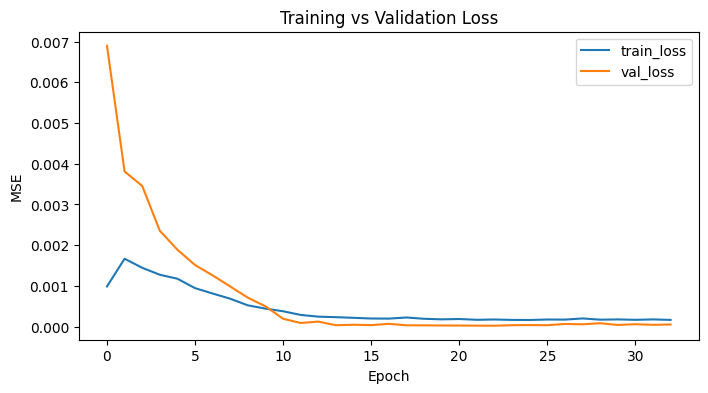

(Text(0.5, 24.0, 'Epoch'),
 Text(24.0, 0.5, 'MSE'),
 None)

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch'), plt.ylabel('MSE'), plt.legend(), plt.show()

# 6. Evaluasi Model GRU pada Data Testing

**Tujuan Akhir:**
Mengevaluasi performa model GRU pada data testing untuk memastikan kemampuan generalisasi model terhadap data yang belum pernah dilihat sebelumnya.

**Langkah-langkah**:
1. **Prediksi pada Data Testing**:
   - Model GRU melakukan prediksi terhadap `X_test`.
   - Hasil prediksi (`y_pred_s`) diratakan dengan `.flatten()` agar satu dimensi.

2. **Inverse Transform ke Skala Asli**:
   - Karena data sebelumnya telah dinormalisasi dengan `MinMaxScaler`, maka nilai asli perlu dikembalikan dengan `inverse_transform()`:
     - `y_test_true`: nilai aktual yang telah dikembalikan ke skala asli.
     - `y_pred_true`: hasil prediksi model dalam skala asli.

3. **Menghitung Metrik Evaluasi**:
   - **RMSE (Root Mean Squared Error)**: rata-rata akar kuadrat dari error prediksi.
   - **MAE (Mean Absolute Error)**: rata-rata absolut selisih antara prediksi dan nilai aktual.
   - **MAPE (Mean Absolute Percentage Error)**: rata-rata persentase kesalahan terhadap nilai aktual.
   - **R² (R-squared Score)**: proporsi variansi yang dijelaskan oleh model (nilai mendekati 1 lebih baik).

**Keuntungan:**
- Memberikan gambaran menyeluruh tentang performa model pada data testing.
- Memastikan model tidak hanya bekerja baik pada data training tetapi juga pada data baru.
- Visualisasi membantu mengidentifikasi pola kesalahan atau deviasi prediksi.

**Output:**
- Nilai metrik evaluasi (RMSE, MAE, MAPE, R²) yang menunjukkan performa model.
- Grafik perbandingan antara nilai aktual dan prediksi pada data testing.

**Insight:**
- Nilai RMSE dan MAE yang rendah menunjukkan prediksi model akurat.
- MAPE di bawah 10% dianggap sangat baik untuk model prediktif.
- Nilai R² mendekati 1 menunjukkan model mampu menjelaskan variansi data dengan baik.
- Grafik aktual vs prediksi membantu mengidentifikasi area di mana model mungkin kurang akurat.

In [ ]:
y_pred_s = model_gru.predict(X_test).flatten()
y_test_true = gold_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_true = gold_scaler.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
rmse = np.sqrt(mean_squared_error(y_test_true, y_pred_true))
mae  = mean_absolute_error(y_test_true, y_pred_true)
mape = np.mean(np.abs((y_test_true-y_pred_true)/y_test_true))*100
r2   = r2_score(y_test_true, y_pred_true)
print(f"Test RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Test RMSE: 19.55, MAE: 13.44, MAPE: 0.62%, R2: 0.9971


### **Insight**
1. **Akurasi Tinggi**: Nilai MAPE yang sangat rendah (di bawah 1%) menunjukkan bahwa model memiliki kemampuan prediksi yang sangat akurat.
2. **Generalizability**: Nilai R² sebesar 0.9945 mengindikasikan bahwa model dapat menjelaskan sebagian besar variansi data testing, meskipun masih ada ruang untuk perbaikan.
3. **Kesalahan Prediksi**: RMSE dan MAE menunjukkan bahwa kesalahan prediksi rata-rata cukup kecil, sehingga model dapat diandalkan untuk memprediksi harga emas.


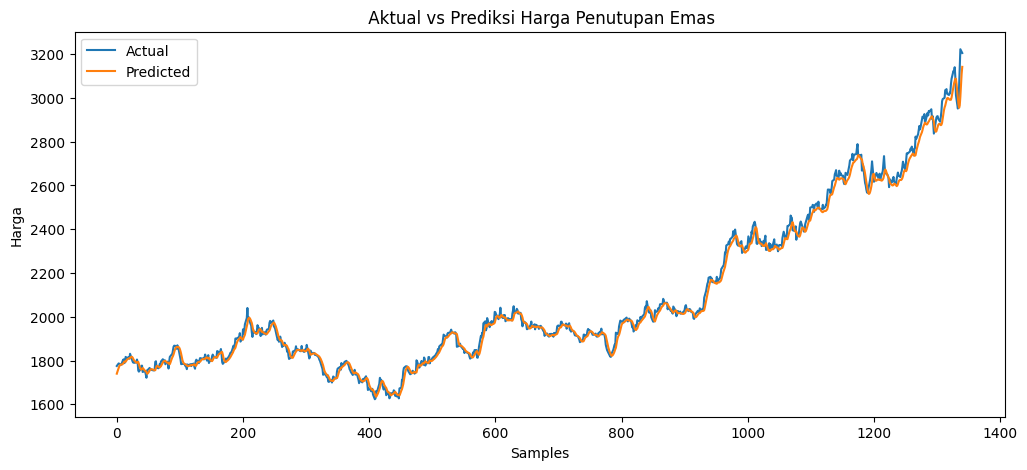

(Text(0.5, 24.0, 'Samples'),
 Text(24.0, 0.5, 'Harga'),
 None)

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_test_true, label='Actual')
plt.plot(y_pred_true, label='Predicted')
plt.title(' Aktual vs Prediksi Harga Penutupan Emas')
plt.xlabel('Samples'), plt.ylabel('Harga'), plt.legend(), plt.show()

### **Insight:**

* Pola prediksi cukup **mirip dengan data aktual**, menandakan bahwa model memiliki performa yang baik dalam menangkap tren naik turun harga.
* Terdapat **sedikit deviasi** antara nilai aktual dan prediksi, terutama saat terjadi lonjakan atau penurunan harga yang tajam.
* Model berhasil memprediksi **arah pergerakan harga** dengan cukup baik, meskipun terdapat **beberapa perbedaan nilai absolut**.

# 7. Menyimpan Model dan Scaler

**Tujuan Akhir:**
Menyimpan model GRU yang telah dilatih dan scaler `MinMaxScaler` agar dapat digunakan kembali tanpa perlu melatih ulang model.

**Langkah:**
- **1**: Menyimpan model GRU terlatih ke file `.h5` menggunakan `model.save()`.
- **2**: Menyimpan scaler yang digunakan untuk normalisasi data ke file `.pkl` menggunakan `pickle.dump()`.

**Keuntungan:**
- Memungkinkan penggunaan kembali model dan scaler tanpa perlu melatih ulang, sehingga menghemat waktu dan sumber daya.
- Memastikan konsistensi dalam preprocessing data saat model digunakan untuk prediksi di masa depan.

**Output:**
- File `best_model_gru.h5` yang berisi model GRU terlatih.
- File `scaler_close_gru.pkl` yang berisi scaler untuk normalisasi data.

**Insight:**
- Dengan menyimpan model dan scaler, pipeline prediksi dapat diotomatisasi untuk digunakan di masa depan tanpa perlu mengulangi proses pelatihan.

In [ ]:
model_path = 'best_model_gru.h5'
scaler_path = 'scaler_close_gru.pkl'

model_gru.save(model_path)
pickle.dump(gold_scaler, open(scaler_path, 'wb'))

print('Best GRU model dan scaler berhasil disimpan')

Best GRU model dan scaler berhasil disimpan


Menyimpan Dataset

In [ ]:
gold.to_csv('gold_dataset.csv', index=False)

# 8. Inference

In [ ]:
def predict_until_date_gold(start_date_str, end_date_str, last_gold_df, scaler, window_size=60):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    n_days = (end_date - start_date).days + 1

    if len(last_gold_df) < window_size:
        raise ValueError(f"Minimal {window_size} data diperlukan untuk prediksi.")

    # Ambil 60 harga terakhir dan normalisasi
    recent_prices = last_gold_df['close'].values[-window_size:].reshape(-1, 1)
    scaled_input = scaler.transform(recent_prices)
    current_input = scaled_input.copy()

    predictions = []

    for i in range(n_days):
        input_seq = current_input.reshape(1, window_size, 1)

        # Prediksi (masih dalam skala 0-1)
        pred_scaled = model.predict(input_seq, verbose=0)

        # Ubah kembali ke skala harga emas asli
        pred_actual = scaler.inverse_transform(pred_scaled)[0][0]

        predictions.append({
            'Date': start_date + timedelta(days=i),
            'Predicted_Close': round(pred_actual, 2)  # dibulatkan agar rapi
        })

        # Update input dengan prediksi baru
        current_input = np.append(current_input, pred_scaled)[1:]

    return pd.DataFrame(predictions)

In [ ]:
# Load model dan scaler
model = load_model('/content/best_model_gru.h5', custom_objects={'mse': MeanSquaredError()})
scaler = pickle.load(open('/content/scaler_close_gru.pkl', 'rb'))

# Load data historis terakhir
last_data = gold.drop(columns=['close_s'])
last_data['Date'] = pd.to_datetime(gold['timestamp'])

# Prediksi dari 15 April sampai 20 April 2025
predicted_df = predict_until_date_gold('2025-04-15', '2025-04-20', gold, scaler, window_size=60)

print(predicted_df)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


        Date  Predicted_Close
0 2025-04-15      3160.500000
1 2025-04-16      3159.879883
2 2025-04-17      3152.689941
3 2025-04-18      3142.810059
4 2025-04-19      3131.870117
5 2025-04-20      3120.540039


In [ ]:
def plot_gold_prediction_from_april(last_data, prediction_df):
    # Pastikan kolom nama 'Date'
    if 'Date' not in last_data.columns and 'date' in last_data.columns:
        last_data = last_data.rename(columns={'date': 'Date'})
    if 'Date' not in prediction_df.columns and 'date' in prediction_df.columns:
        prediction_df = prediction_df.rename(columns={'date': 'Date'})

    # Pastikan kolom tanggal dalam datetime
    last_data['Date'] = pd.to_datetime(last_data['Date'])
    prediction_df['Date'] = pd.to_datetime(prediction_df['Date'])

    # Filter dari 1 April
    filtered_history = last_data[last_data['Date'] >= pd.to_datetime('2025-04-01')]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_history['Date'], filtered_history['close'], label='Harga Historis', color='blue')
    plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Prediksi', color='orange', linestyle='--', marker='o')

    plt.title('Prediksi Harga Emas 15 April 2025 - 20 April 2025')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Emas (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

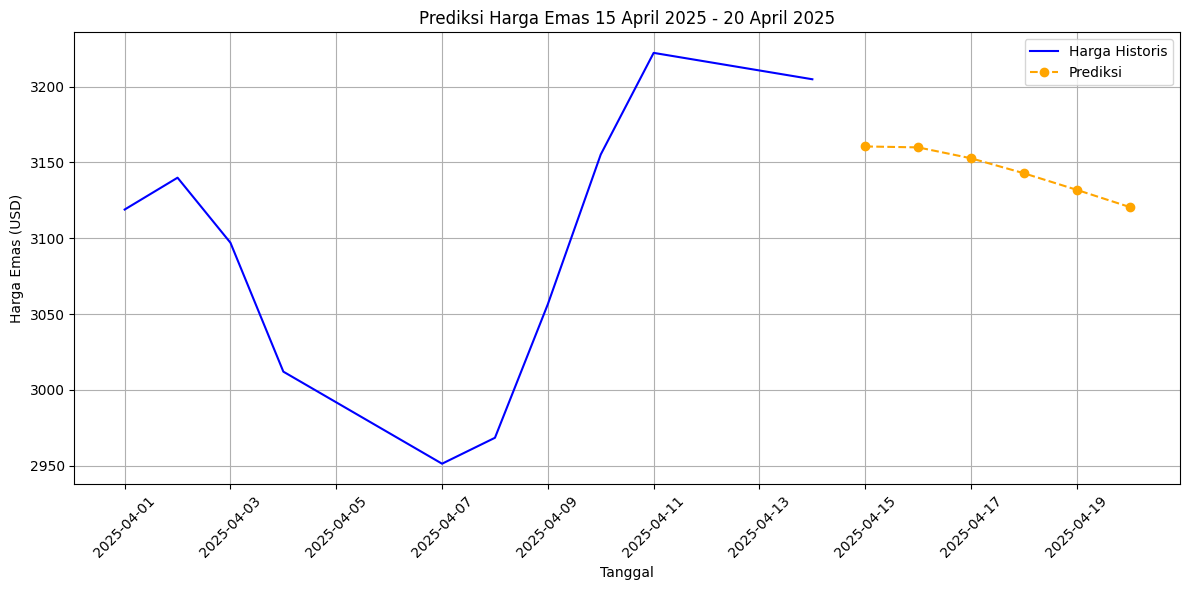

In [ ]:
plot_gold_prediction_from_april(last_data, predicted_df)

Dari hasil inference menunjukkan bahwa hasil prediksi untuk 6 hari kedepan harga emas cenderung menurun.

# 9. Kesimpulan Hasil

Berdasarkan hasil dari seluruh proses dalam notebook ini, berikut adalah poin-poin utama yang dapat disimpulkan:

1. **Model GRU untuk Prediksi Harga Emas**:  
   - Model GRU berhasil dibangun dan dilatih menggunakan data historis harga emas dari tahun 2000 hingga 2025.  
   - Proses meliputi preprocessing data, pembentukan data time series, tuning hyperparameter, pelatihan model, dan evaluasi performa.

2. **Parameter Terbaik Hasil Hyperparameter Tuning**:  
   - Hasil tuning hyperparameter menggunakan `Hyperopt` menghasilkan kombinasi parameter terbaik sebagai berikut:  
     - **Units**: 64  
     - **Dropout**: 0.2397  
     - **Learning Rate (lr)**: 0.0009
     - **Batch Size**: 32  
     - **Epochs**: 100  

3. **Evaluasi Model**  
   Model menunjukkan performa yang sangat baik pada data testing dengan metrik evaluasi sebagai berikut:

| **Metrik** | **Nilai** | **Interpretasi** |
|------------|-----------|----------------------------------------------------------------------------------------------|
| **RMSE**   | 19.55     | Rata-rata kesalahan prediksi adalah 19.55  unit harga emas, menunjukkan akurasi yang baik.    |
| **MAE**    | 13.44     | Deviasi rata-rata absolut antara prediksi dan nilai aktual adalah 13.44 unit.               |
| **MAPE**   | 0.62%     | Model hanya meleset sekitar 0.62% dari nilai aktual secara rata-rata, sangat akurat.         |
| **R²**     | 0.9971    | Model mampu menjelaskan 99.71% variansi data, menunjukkan performa yang sangat baik.         |

4. **Visualisasi Hasil**:  
   - Grafik perbandingan antara nilai aktual dan prediksi menunjukkan bahwa model mampu menangkap pola pergerakan harga emas dengan baik.  
   - Terdapat sedikit deviasi pada lonjakan harga yang tajam, namun secara keseluruhan model dapat memprediksi arah pergerakan harga dengan akurat.

5. **Pipeline yang Reproducible**:  
   - Model GRU dan scaler telah disimpan dalam file (`.h5` dan `.pkl`), sehingga dapat digunakan kembali tanpa perlu melatih ulang model.  
   - Pipeline ini dapat diotomatisasi untuk prediksi harga emas di masa depan.

---

### **Business Decisions**

Berdasarkan hasil yang diperoleh, berikut beberapa keputusan bisnis yang dapat dipertimbangkan:

1. **Pendukung Strategi Investasi**

   * Model dapat dijadikan alat bantu prediksi harga emas jangka pendek, mendukung pengambilan keputusan jual-beli.
   * Dengan akurasi tinggi (MAPE 0.87%), model cocok diterapkan dalam strategi investasi berbasis data.

2. **Manajemen Risiko yang Lebih Baik**

   * Prediksi harga dapat digunakan untuk mendeteksi potensi volatilitas, sehingga mendukung alokasi aset yang lebih optimal.

3. **Pengembangan Produk Finansial**

   * Institusi keuangan dapat memanfaatkan model ini dalam menciptakan produk derivatif seperti kontrak berjangka dan tabungan emas.
   * Prediksi harga juga dapat digunakan untuk menetapkan harga produk berbasis emas lainnya.

4. **Peningkatan Model Lebih Lanjut**

   * Kinerja model masih dapat ditingkatkan dengan memasukkan variabel eksternal, seperti indikator ekonomi atau sentimen pasar.
   * Eksperimen dengan arsitektur model lain seperti Transformer juga layak untuk dilakukan guna menangkap pola temporal yang lebih kompleks.

---

### **Kesimpulan Akhir**

Model GRU yang dibangun berhasil memberikan hasil prediksi harga emas dengan performa tinggi dan tingkat akurasi yang sangat baik. Meskipun demikian, model tersebut hanya sebatas unvariat, sehingga perlu memperhatikan faktor eksternal juga. Untuk kedepannya bisa dikembangkan lagi menjadin model multivariat yang benar-benar lebih akurat.
